In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Size of data split for testing
train_size = 0.8

In [6]:
# Normalise data
normaliser = preprocessing.MinMaxScaler()
data_norm = normaliser.fit_transform(data)

In [7]:
# Normalised chunks
historical_sequences_norm = np.array([data_norm[i : i + backlook].copy() for i in range(len(data_norm) - backlook)])
next_day_values_norm = np.array([data_norm[i + backlook].copy() for i in range(len(data_norm) - backlook)])

In [8]:
# Y raw data
next_day_values = np.array([data.to_numpy()[i + backlook] for i in range(len(data) - backlook)])

In [9]:
# Train-Test split
split = int(historical_sequences_norm.shape[0] * train_size)

X_train = historical_sequences_norm[:split]
Y_train = next_day_values_norm[:split]

X_test = historical_sequences_norm[split:]
Y_test = next_day_values_norm[split:]
unscaled_y_test = next_day_values[split:]

# Model selection

##### Model constructor

In [10]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(y.shape[-1], activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [11]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [12]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [13]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 1s 377us/step - loss: 1.2303 - val_loss: 0.0676
Epoch 2/24
3690/3690 [==============================] - 1s 158us/step - loss: 0.1703 - val_loss: 0.0443
Epoch 3/24
3690/3690 [==============================] - 1s 160us/step - loss: 0.0978 - val_loss: 0.0294
Epoch 4/24
3690/3690 [==============================] - 1s 159us/step - loss: 0.0634 - val_loss: 0.0537
Epoch 5/24
3690/3690 [==============================] - 1s 162us/step - loss: 0.0602 - val_loss: 0.0532
Epoch 6/24
3690/3690 [==============================] - 1s 170us/step - loss: 0.0498 - val_loss: 0.0222
Epoch 7/24
3690/3690 [==============================] - 1s 158us/step - loss: 0.0394 - val_loss: 0.0468
Epoch 8/24
3690/3690 [==============================] - 1s 160us/step - loss: 0.0380 - val

3690/3690 [==============================] - 2s 447us/step - loss: 0.0050 - val_loss: 0.0366
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 2s 658us/step - loss: 0.4185 - val_loss: 0.0083
Epoch 2/24
3690/3690 [==============================] - 2s 459us/step - loss: 0.0064 - val_loss: 0.0032
Epoch 3/24
3690/3690 [==============================] - 2s 450us/step - loss: 0.0037 - val_loss: 0.0204
Epoch 4/24
3690/3690 [==============================] - 2s 444us/step - loss: 0.0146 - val_loss: 0.0018
Epoch 5/24
3690/3690 [==============================] - 2s 448us/step - loss: 0.0116 - val_loss: 0.0229
Epoch 6/24
3690/3690 [==============================] - 2s 455us/step - loss: 0.0106 - val_loss: 0.0350
Epoch 7/24
3690/3690 [==============================] - 2s 447us/step - loss: 0.0152 - val_loss: 0.0408
Epoch 8/24
3690/3690 [==============================] - 2s 449us/step - loss: 0.0284 - val_loss: 0.0022
Epoch 9/24
3690/3690 [======

3690/3690 [==============================] - 2s 469us/step - loss: 0.0158 - val_loss: 0.0101
Epoch 5/24
3690/3690 [==============================] - 2s 468us/step - loss: 0.0163 - val_loss: 0.0060
Epoch 6/24
3690/3690 [==============================] - 2s 472us/step - loss: 0.0078 - val_loss: 0.0222
Epoch 7/24
3690/3690 [==============================] - 2s 471us/step - loss: 0.0382 - val_loss: 0.0297
Epoch 8/24
3690/3690 [==============================] - 2s 466us/step - loss: 0.0175 - val_loss: 0.0051
Epoch 9/24
3690/3690 [==============================] - 2s 469us/step - loss: 0.0089 - val_loss: 0.0309
Epoch 10/24
3690/3690 [==============================] - 2s 471us/step - loss: 0.0153 - val_loss: 0.0239
Epoch 11/24
3690/3690 [==============================] - 2s 471us/step - loss: 0.0399 - val_loss: 0.0116
Epoch 12/24
3690/3690 [==============================] - 2s 469us/step - loss: 0.0058 - val_loss: 0.0041
Epoch 13/24
3690/3690 [==============================] - 2s 469us/step -

3690/3690 [==============================] - 2s 572us/step - loss: 0.0088 - val_loss: 0.0039
Epoch 10/24
3690/3690 [==============================] - 2s 567us/step - loss: 0.0054 - val_loss: 0.0188
Epoch 11/24
3690/3690 [==============================] - 2s 571us/step - loss: 0.0113 - val_loss: 0.0162
Epoch 12/24
3690/3690 [==============================] - 2s 579us/step - loss: 0.0071 - val_loss: 0.0071
Epoch 13/24
3690/3690 [==============================] - 2s 573us/step - loss: 0.0069 - val_loss: 0.0088
Epoch 14/24
3690/3690 [==============================] - 2s 568us/step - loss: 0.0062 - val_loss: 0.0060
Epoch 15/24
3690/3690 [==============================] - 2s 572us/step - loss: 0.0114 - val_loss: 0.0194
Epoch 16/24
3690/3690 [==============================] - 2s 571us/step - loss: 0.0128 - val_loss: 0.0084
Epoch 17/24
3690/3690 [==============================] - 2s 568us/step - loss: 0.0073 - val_loss: 0.0085
Epoch 18/24
3690/3690 [==============================] - 2s 572us/s

Epoch 14/24
3690/3690 [==============================] - 2s 466us/step - loss: 0.0062 - val_loss: 0.0030
Epoch 15/24
3690/3690 [==============================] - 2s 472us/step - loss: 0.0048 - val_loss: 0.0028
Epoch 16/24
3690/3690 [==============================] - 2s 473us/step - loss: 0.0052 - val_loss: 0.0024
Epoch 17/24
3690/3690 [==============================] - 2s 468us/step - loss: 0.0050 - val_loss: 0.0054
Epoch 18/24
3690/3690 [==============================] - 2s 471us/step - loss: 0.0056 - val_loss: 0.0058
Epoch 19/24
3690/3690 [==============================] - 2s 470us/step - loss: 0.0061 - val_loss: 0.0023
Epoch 20/24
3690/3690 [==============================] - 2s 474us/step - loss: 0.0037 - val_loss: 0.0057
Epoch 21/24
3690/3690 [==============================] - 2s 468us/step - loss: 0.0073 - val_loss: 0.0065
Epoch 22/24
3690/3690 [==============================] - 2s 469us/step - loss: 0.0043 - val_loss: 0.0059
Epoch 23/24
3690/3690 [==============================] 

3690/3690 [==============================] - 2s 545us/step - loss: 0.0030 - val_loss: 0.0014
Epoch 19/24
3690/3690 [==============================] - 2s 549us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 20/24
3690/3690 [==============================] - 2s 551us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 21/24
3690/3690 [==============================] - 2s 554us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 22/24
3690/3690 [==============================] - 2s 554us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 23/24
3690/3690 [==============================] - 2s 552us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 24/24
3690/3690 [==============================] - 2s 550us/step - loss: 0.0024 - val_loss: 0.0031
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 3s 875us/step - loss: 0.3799 - val_loss: 0.0075
Epoch 2/24
3690/3690 [==============================] - 1s 330us/step - loss: 0.0134 - val_loss: 0.0032
Epoch 3/24
3690/3690 [

3690/3690 [==============================] - 2s 552us/step - loss: 0.0032 - val_loss: 0.0039
Epoch 24/24
3690/3690 [==============================] - 2s 553us/step - loss: 0.0029 - val_loss: 0.0034

GENERATION 2

Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 4s 1ms/step - loss: 0.0703 - val_loss: 0.0151
Epoch 2/24
3690/3690 [==============================] - 2s 467us/step - loss: 0.0104 - val_loss: 0.0043
Epoch 3/24
3690/3690 [==============================] - 2s 474us/step - loss: 0.0055 - val_loss: 0.0033
Epoch 4/24
3690/3690 [==============================] - 2s 472us/step - loss: 0.0042 - val_loss: 0.0014
Epoch 5/24
3690/3690 [==============================] - 2s 469us/step - loss: 0.0034 - val_loss: 0.0017
Epoch 6/24
3690/3690 [==============================] - 2s 468us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 7/24
3690/3690 [==============================] - 2s 475us/step - loss: 0.0028 - val_loss: 0.0011
Epoch 8/24
369

3690/3690 [==============================] - 2s 469us/step - loss: 0.0426 - val_loss: 0.0205
Epoch 4/24
3690/3690 [==============================] - 2s 473us/step - loss: 0.0354 - val_loss: 0.0058
Epoch 5/24
3690/3690 [==============================] - 2s 470us/step - loss: 0.0197 - val_loss: 0.0095
Epoch 6/24
3690/3690 [==============================] - 2s 472us/step - loss: 0.0075 - val_loss: 0.0331
Epoch 7/24
3690/3690 [==============================] - 2s 470us/step - loss: 0.0050 - val_loss: 0.0048
Epoch 8/24
3690/3690 [==============================] - 2s 472us/step - loss: 0.0039 - val_loss: 0.0037
Epoch 9/24
3690/3690 [==============================] - 2s 478us/step - loss: 0.0032 - val_loss: 0.0047
Epoch 10/24
3690/3690 [==============================] - 2s 482us/step - loss: 0.0029 - val_loss: 0.0036
Epoch 11/24
3690/3690 [==============================] - 2s 475us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 12/24
3690/3690 [==============================] - 2s 471us/step - 

3690/3690 [==============================] - 2s 516us/step - loss: 0.0565 - val_loss: 0.0298
Epoch 9/24
3690/3690 [==============================] - 2s 521us/step - loss: 0.0563 - val_loss: 0.0318
Epoch 10/24
3690/3690 [==============================] - 2s 527us/step - loss: 0.0562 - val_loss: 0.0317
Epoch 11/24
3690/3690 [==============================] - 2s 532us/step - loss: 0.0562 - val_loss: 0.0331
Epoch 12/24
3690/3690 [==============================] - 2s 524us/step - loss: 0.0562 - val_loss: 0.0330
Epoch 13/24
3690/3690 [==============================] - 2s 520us/step - loss: 0.0562 - val_loss: 0.0317
Epoch 14/24
3690/3690 [==============================] - 2s 524us/step - loss: 0.0562 - val_loss: 0.0314
Epoch 15/24
3690/3690 [==============================] - 2s 526us/step - loss: 0.0562 - val_loss: 0.0316
Epoch 16/24
3690/3690 [==============================] - 2s 522us/step - loss: 0.0562 - val_loss: 0.0320
Epoch 17/24
3690/3690 [==============================] - 2s 522us/st

Epoch 13/24
3690/3690 [==============================] - 1s 343us/step - loss: 0.0114 - val_loss: 0.0120
Epoch 14/24
3690/3690 [==============================] - 1s 338us/step - loss: 0.0088 - val_loss: 0.0028
Epoch 15/24
3690/3690 [==============================] - 1s 340us/step - loss: 0.0045 - val_loss: 0.0051
Epoch 16/24
3690/3690 [==============================] - 1s 343us/step - loss: 0.0087 - val_loss: 0.0057
Epoch 17/24
3690/3690 [==============================] - 1s 335us/step - loss: 0.0094 - val_loss: 0.0110
Epoch 18/24
3690/3690 [==============================] - 1s 338us/step - loss: 0.0092 - val_loss: 0.0162
Epoch 19/24
3690/3690 [==============================] - 1s 339us/step - loss: 0.0107 - val_loss: 0.0085
Epoch 20/24
3690/3690 [==============================] - 1s 345us/step - loss: 0.0065 - val_loss: 0.0214
Epoch 21/24
3690/3690 [==============================] - 1s 337us/step - loss: 0.0100 - val_loss: 0.0054
Epoch 22/24
3690/3690 [==============================] 

3690/3690 [==============================] - 2s 464us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 18/24
3690/3690 [==============================] - 2s 466us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 19/24
3690/3690 [==============================] - 2s 464us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 20/24
3690/3690 [==============================] - 2s 468us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 21/24
3690/3690 [==============================] - 2s 470us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 22/24
3690/3690 [==============================] - 2s 472us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 23/24
3690/3690 [==============================] - 2s 468us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 24/24
3690/3690 [==============================] - 2s 466us/step - loss: 0.0022 - val_loss: 0.0011
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 5s 1ms/step - loss: 0.1256 - val_loss: 0.0599
Epoch 2/24
3690/3690 [=

3690/3690 [==============================] - 2s 469us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 23/24
3690/3690 [==============================] - 2s 464us/step - loss: 0.0020 - val_loss: 9.4721e-04
Epoch 24/24
3690/3690 [==============================] - 2s 468us/step - loss: 0.0020 - val_loss: 0.0016
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 6s 2ms/step - loss: 0.0832 - val_loss: 0.0232
Epoch 2/24
3690/3690 [==============================] - 2s 469us/step - loss: 0.0366 - val_loss: 0.0206
Epoch 3/24
3690/3690 [==============================] - 2s 466us/step - loss: 0.0206 - val_loss: 0.0066
Epoch 4/24
3690/3690 [==============================] - 2s 472us/step - loss: 0.0110 - val_loss: 0.0149
Epoch 5/24
3690/3690 [==============================] - 2s 472us/step - loss: 0.0065 - val_loss: 0.0083
Epoch 6/24
3690/3690 [==============================] - 2s 475us/step - loss: 0.0040 - val_loss: 0.0028
Epoch 7/24
3690/3690 [==

3690/3690 [==============================] - 2s 471us/step - loss: 0.0137 - val_loss: 0.0052
Epoch 3/24
3690/3690 [==============================] - 2s 478us/step - loss: 0.0075 - val_loss: 0.0038
Epoch 4/24
3690/3690 [==============================] - 2s 478us/step - loss: 0.0048 - val_loss: 0.0020
Epoch 5/24
3690/3690 [==============================] - 2s 481us/step - loss: 0.0040 - val_loss: 0.0031
Epoch 6/24
3690/3690 [==============================] - 2s 471us/step - loss: 0.0036 - val_loss: 0.0015
Epoch 7/24
3690/3690 [==============================] - 2s 476us/step - loss: 0.0031 - val_loss: 0.0014
Epoch 8/24
3690/3690 [==============================] - 2s 477us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 9/24
3690/3690 [==============================] - 2s 478us/step - loss: 0.0028 - val_loss: 0.0015
Epoch 10/24
3690/3690 [==============================] - 2s 469us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 11/24
3690/3690 [==============================] - 2s 478us/step - l

3690/3690 [==============================] - 2s 582us/step - loss: 0.0041 - val_loss: 0.0021
Epoch 8/24
3690/3690 [==============================] - 2s 578us/step - loss: 0.0039 - val_loss: 0.0018
Epoch 9/24
3690/3690 [==============================] - 2s 584us/step - loss: 0.0037 - val_loss: 0.0022
Epoch 10/24
3690/3690 [==============================] - 2s 578us/step - loss: 0.0036 - val_loss: 0.0014
Epoch 11/24
3690/3690 [==============================] - 2s 584us/step - loss: 0.0035 - val_loss: 0.0020
Epoch 12/24
3690/3690 [==============================] - 2s 580us/step - loss: 0.0035 - val_loss: 0.0012
Epoch 13/24
3690/3690 [==============================] - 2s 578us/step - loss: 0.0036 - val_loss: 0.0014
Epoch 14/24
3690/3690 [==============================] - 2s 584us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 15/24
3690/3690 [==============================] - 2s 578us/step - loss: 0.0034 - val_loss: 0.0015
Epoch 16/24
3690/3690 [==============================] - 2s 584us/ste

3690/3690 [==============================] - 2s 492us/step - loss: 0.0044 - val_loss: 0.0017
Epoch 13/24
3690/3690 [==============================] - 2s 503us/step - loss: 0.0044 - val_loss: 0.0017
Epoch 14/24
3690/3690 [==============================] - 2s 496us/step - loss: 0.0046 - val_loss: 0.0017
Epoch 15/24
3690/3690 [==============================] - 2s 498us/step - loss: 0.0043 - val_loss: 0.0018
Epoch 16/24
3690/3690 [==============================] - 2s 507us/step - loss: 0.0043 - val_loss: 0.0027
Epoch 17/24
3690/3690 [==============================] - 2s 497us/step - loss: 0.0044 - val_loss: 0.0017
Epoch 18/24
3690/3690 [==============================] - 2s 499us/step - loss: 0.0041 - val_loss: 0.0017
Epoch 19/24
3690/3690 [==============================] - 2s 509us/step - loss: 0.0041 - val_loss: 0.0017
Epoch 20/24
3690/3690 [==============================] - 2s 501us/step - loss: 0.0040 - val_loss: 0.0016
Epoch 21/24
3690/3690 [==============================] - 2s 499us/s

3690/3690 [==============================] - 2s 477us/step - loss: 0.0025 - val_loss: 9.9363e-04
Epoch 17/24
3690/3690 [==============================] - 2s 478us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 18/24
3690/3690 [==============================] - 2s 475us/step - loss: 0.0025 - val_loss: 0.0011
Epoch 19/24
3690/3690 [==============================] - 2s 471us/step - loss: 0.0024 - val_loss: 9.8387e-04
Epoch 20/24
3690/3690 [==============================] - 2s 477us/step - loss: 0.0023 - val_loss: 9.5235e-04
Epoch 21/24
3690/3690 [==============================] - 2s 479us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 22/24
3690/3690 [==============================] - 2s 475us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 23/24
3690/3690 [==============================] - 2s 473us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 24/24
3690/3690 [==============================] - 2s 479us/step - loss: 0.0023 - val_loss: 0.0010
Train on 3690 samples, validate on 410 samples
Epoch 1/

Epoch 21/24
3690/3690 [==============================] - 2s 426us/step - loss: 0.0027 - val_loss: 0.0012
Epoch 22/24
3690/3690 [==============================] - 2s 426us/step - loss: 0.0026 - val_loss: 0.0011
Epoch 23/24
3690/3690 [==============================] - 2s 427us/step - loss: 0.0027 - val_loss: 0.0012
Epoch 24/24
3690/3690 [==============================] - 2s 430us/step - loss: 0.0026 - val_loss: 0.0011
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 8s 2ms/step - loss: 0.0602 - val_loss: 0.0188
Epoch 2/24
3690/3690 [==============================] - 2s 479us/step - loss: 0.0116 - val_loss: 0.0087
Epoch 3/24
3690/3690 [==============================] - 2s 477us/step - loss: 0.0076 - val_loss: 0.0012
Epoch 4/24
3690/3690 [==============================] - 2s 473us/step - loss: 0.0053 - val_loss: 0.0027
Epoch 5/24
3690/3690 [==============================] - 2s 482us/step - loss: 0.0045 - val_loss: 0.0022
Epoch 6/24
3690

3690/3690 [==============================] - 8s 2ms/step - loss: 0.0764 - val_loss: 0.0055
Epoch 2/24
3690/3690 [==============================] - 2s 473us/step - loss: 0.0091 - val_loss: 0.0073
Epoch 3/24
3690/3690 [==============================] - 2s 477us/step - loss: 0.0065 - val_loss: 0.0172
Epoch 4/24
3690/3690 [==============================] - 2s 478us/step - loss: 0.0073 - val_loss: 0.0094
Epoch 5/24
3690/3690 [==============================] - 2s 473us/step - loss: 0.0092 - val_loss: 0.0110
Epoch 6/24
3690/3690 [==============================] - 2s 474us/step - loss: 0.0056 - val_loss: 0.0050
Epoch 7/24
3690/3690 [==============================] - 2s 476us/step - loss: 0.0077 - val_loss: 0.0094
Epoch 8/24
3690/3690 [==============================] - 2s 482us/step - loss: 0.0049 - val_loss: 0.0145
Epoch 9/24
3690/3690 [==============================] - 2s 476us/step - loss: 0.0075 - val_loss: 0.0017
Epoch 10/24
3690/3690 [==============================] - 2s 474us/step - loss

Epoch 6/24
3690/3690 [==============================] - 2s 473us/step - loss: 0.0056 - val_loss: 0.0019
Epoch 7/24
3690/3690 [==============================] - 2s 477us/step - loss: 0.0052 - val_loss: 0.0020
Epoch 8/24
3690/3690 [==============================] - 2s 477us/step - loss: 0.0049 - val_loss: 0.0029
Epoch 9/24
3690/3690 [==============================] - 2s 476us/step - loss: 0.0047 - val_loss: 0.0025
Epoch 10/24
3690/3690 [==============================] - 2s 471us/step - loss: 0.0045 - val_loss: 0.0020
Epoch 11/24
3690/3690 [==============================] - 2s 486us/step - loss: 0.0045 - val_loss: 0.0016
Epoch 12/24
3690/3690 [==============================] - 2s 480us/step - loss: 0.0043 - val_loss: 0.0021
Epoch 13/24
3690/3690 [==============================] - 2s 480us/step - loss: 0.0042 - val_loss: 0.0019
Epoch 14/24
3690/3690 [==============================] - 2s 478us/step - loss: 0.0040 - val_loss: 0.0017
Epoch 15/24
3690/3690 [==============================] - 2s

3690/3690 [==============================] - 2s 479us/step - loss: 0.0035 - val_loss: 0.0015
Epoch 12/24
3690/3690 [==============================] - 2s 475us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 13/24
3690/3690 [==============================] - 2s 482us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 14/24
3690/3690 [==============================] - 2s 482us/step - loss: 0.0033 - val_loss: 0.0015
Epoch 15/24
3690/3690 [==============================] - 2s 482us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 16/24
3690/3690 [==============================] - 2s 481us/step - loss: 0.0032 - val_loss: 0.0013
Epoch 17/24
3690/3690 [==============================] - 2s 481us/step - loss: 0.0031 - val_loss: 0.0015
Epoch 18/24
3690/3690 [==============================] - 2s 482us/step - loss: 0.0031 - val_loss: 0.0014
Epoch 19/24
3690/3690 [==============================] - 2s 488us/step - loss: 0.0030 - val_loss: 0.0014
Epoch 20/24
3690/3690 [==============================] - 2s 478us/s

3690/3690 [==============================] - 1s 389us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 17/24
3690/3690 [==============================] - 1s 395us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 18/24
3690/3690 [==============================] - 1s 395us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 19/24
3690/3690 [==============================] - 1s 394us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 20/24
3690/3690 [==============================] - 1s 395us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 21/24
3690/3690 [==============================] - 1s 392us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 22/24
3690/3690 [==============================] - 1s 395us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 23/24
3690/3690 [==============================] - 1s 390us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 24/24
3690/3690 [==============================] - 1s 395us/step - loss: 0.0018 - val_loss: 0.0010

GENERATION 7

Train on 3690 samples, validate on 410 samples
Epoch

3690/3690 [==============================] - 2s 423us/step - loss: nan - val_loss: nan
Epoch 23/24
3690/3690 [==============================] - 2s 425us/step - loss: nan - val_loss: nan
Epoch 24/24
3690/3690 [==============================] - 2s 421us/step - loss: nan - val_loss: nan
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 11s 3ms/step - loss: 0.1413 - val_loss: 0.0159
Epoch 2/24
3690/3690 [==============================] - 2s 569us/step - loss: 0.0141 - val_loss: 0.0048
Epoch 3/24
3690/3690 [==============================] - 2s 564us/step - loss: 0.0074 - val_loss: 0.0042
Epoch 4/24
3690/3690 [==============================] - 2s 571us/step - loss: 0.0054 - val_loss: 0.0033
Epoch 5/24
3690/3690 [==============================] - 2s 566us/step - loss: 0.0039 - val_loss: 0.0020
Epoch 6/24
3690/3690 [==============================] - 2s 565us/step - loss: 0.0037 - val_loss: 0.0020
Epoch 7/24
3690/3690 [=======================

Epoch 3/24
3690/3690 [==============================] - 2s 498us/step - loss: 0.0439 - val_loss: 0.0197
Epoch 4/24
3690/3690 [==============================] - 2s 499us/step - loss: 0.0290 - val_loss: 0.0075
Epoch 5/24
3690/3690 [==============================] - 2s 499us/step - loss: 0.0158 - val_loss: 0.0110
Epoch 6/24
3690/3690 [==============================] - 2s 497us/step - loss: 0.0088 - val_loss: 0.0091
Epoch 7/24
3690/3690 [==============================] - 2s 503us/step - loss: 0.0058 - val_loss: 0.0043
Epoch 8/24
3690/3690 [==============================] - 2s 505us/step - loss: 0.0041 - val_loss: 0.0020
Epoch 9/24
3690/3690 [==============================] - 2s 503us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 10/24
3690/3690 [==============================] - 2s 500us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 11/24
3690/3690 [==============================] - 2s 496us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 12/24
3690/3690 [==============================] - 2s 50

Epoch 8/24
3690/3690 [==============================] - 2s 526us/step - loss: 0.0089 - val_loss: 0.0023
Epoch 9/24
3690/3690 [==============================] - 2s 524us/step - loss: 0.0076 - val_loss: 0.0060
Epoch 10/24
3690/3690 [==============================] - 2s 521us/step - loss: 0.0067 - val_loss: 0.0033
Epoch 11/24
3690/3690 [==============================] - 2s 520us/step - loss: 0.0063 - val_loss: 0.0386
Epoch 12/24
3690/3690 [==============================] - 2s 530us/step - loss: 0.0077 - val_loss: 0.0082
Epoch 13/24
3690/3690 [==============================] - 2s 528us/step - loss: 0.0060 - val_loss: 0.0111
Epoch 14/24
3690/3690 [==============================] - 2s 520us/step - loss: 0.0052 - val_loss: 0.0162
Epoch 15/24
3690/3690 [==============================] - 2s 522us/step - loss: 0.0065 - val_loss: 0.0090
Epoch 16/24
3690/3690 [==============================] - 2s 527us/step - loss: 0.0045 - val_loss: 0.0177
Epoch 17/24
3690/3690 [==============================] - 

Epoch 13/24
3690/3690 [==============================] - 1s 391us/step - loss: 0.0562 - val_loss: 0.0314
Epoch 14/24
3690/3690 [==============================] - 1s 393us/step - loss: 0.0562 - val_loss: 0.0316
Epoch 15/24
3690/3690 [==============================] - 1s 397us/step - loss: 0.0562 - val_loss: 0.0319
Epoch 16/24
3690/3690 [==============================] - 1s 395us/step - loss: 0.0562 - val_loss: 0.0316
Epoch 17/24
3690/3690 [==============================] - 1s 389us/step - loss: 0.0562 - val_loss: 0.0322
Epoch 18/24
3690/3690 [==============================] - 1s 387us/step - loss: 0.0562 - val_loss: 0.0332
Epoch 19/24
3690/3690 [==============================] - 1s 391us/step - loss: 0.0562 - val_loss: 0.0326
Epoch 20/24
3690/3690 [==============================] - 1s 385us/step - loss: 0.0562 - val_loss: 0.0320
Epoch 21/24
3690/3690 [==============================] - 1s 387us/step - loss: 0.0562 - val_loss: 0.0317
Epoch 22/24
3690/3690 [==============================] 

3690/3690 [==============================] - 1s 341us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 14/24
3690/3690 [==============================] - 1s 344us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 15/24
3690/3690 [==============================] - 1s 349us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 16/24
3690/3690 [==============================] - 1s 345us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 17/24
3690/3690 [==============================] - 1s 343us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 18/24
3690/3690 [==============================] - 1s 340us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 19/24
3690/3690 [==============================] - 1s 344us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 20/24
3690/3690 [==============================] - 1s 339us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 21/24
3690/3690 [==============================] - 1s 341us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 22/24
3690/3690 [==============================] - 1s 342us/s

Epoch 18/24
3690/3690 [==============================] - 1s 387us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 19/24
3690/3690 [==============================] - 1s 387us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 20/24
3690/3690 [==============================] - 1s 396us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 21/24
3690/3690 [==============================] - 1s 390us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 22/24
3690/3690 [==============================] - 1s 387us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 23/24
3690/3690 [==============================] - 1s 382us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 24/24
3690/3690 [==============================] - 1s 384us/step - loss: 0.0015 - val_loss: 0.0012
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 14s 4ms/step - loss: 0.0711 - val_loss: 0.0101
Epoch 2/24
3690/3690 [==============================] - 2s 484us/step - loss: 0.0173 - val_loss: 0.0070
Epoch 3/24


Epoch 23/24
3690/3690 [==============================] - 2s 486us/step - loss: 0.0056 - val_loss: 0.0034
Epoch 24/24
3690/3690 [==============================] - 2s 485us/step - loss: 0.0021 - val_loss: 0.0044
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 15s 4ms/step - loss: 0.1554 - val_loss: 0.1453
Epoch 2/24
3690/3690 [==============================] - 2s 483us/step - loss: 0.0935 - val_loss: 0.0953
Epoch 3/24
3690/3690 [==============================] - 2s 488us/step - loss: 0.0720 - val_loss: 0.0709
Epoch 4/24
3690/3690 [==============================] - 2s 489us/step - loss: 0.0614 - val_loss: 0.0564
Epoch 5/24
3690/3690 [==============================] - 2s 486us/step - loss: 0.0549 - val_loss: 0.0467
Epoch 6/24
3690/3690 [==============================] - 2s 497us/step - loss: 0.0509 - val_loss: 0.0404
Epoch 7/24
3690/3690 [==============================] - 2s 484us/step - loss: 0.0480 - val_loss: 0.0354
Epoch 8/24
3690/

3690/3690 [==============================] - 2s 601us/step - loss: 0.0036 - val_loss: 0.0092
Epoch 4/24
3690/3690 [==============================] - 2s 599us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 5/24
3690/3690 [==============================] - 2s 599us/step - loss: 0.0023 - val_loss: 0.0031
Epoch 6/24
3690/3690 [==============================] - 2s 601us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/24
3690/3690 [==============================] - 2s 599us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/24
3690/3690 [==============================] - 2s 594us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 9/24
3690/3690 [==============================] - 2s 598us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 10/24
3690/3690 [==============================] - 2s 603us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 11/24
3690/3690 [==============================] - 2s 596us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/24
3690/3690 [==============================] - 2s 595us/step - 

Epoch 8/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 10/24
3690/3690 [==============================] - 2s 491us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 11/24
3690/3690 [==============================] - 2s 489us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 12/24
3690/3690 [==============================] - 2s 491us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 13/24
3690/3690 [==============================] - 2s 485us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 14/24
3690/3690 [==============================] - 2s 485us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 15/24
3690/3690 [==============================] - 2s 488us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 16/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 17/24
3690/3690 [==============================] - 

Epoch 13/24
3690/3690 [==============================] - 2s 504us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 14/24
3690/3690 [==============================] - 2s 507us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 15/24
3690/3690 [==============================] - 2s 505us/step - loss: 0.0023 - val_loss: 0.0125
Epoch 16/24
3690/3690 [==============================] - 2s 506us/step - loss: 0.0026 - val_loss: 0.0066
Epoch 17/24
3690/3690 [==============================] - 2s 502us/step - loss: 0.0024 - val_loss: 0.0032
Epoch 18/24
3690/3690 [==============================] - 2s 509us/step - loss: 0.0020 - val_loss: 0.0032
Epoch 19/24
3690/3690 [==============================] - 2s 502us/step - loss: 0.0020 - val_loss: 0.0059
Epoch 20/24
3690/3690 [==============================] - 2s 509us/step - loss: 0.0025 - val_loss: 0.0144
Epoch 21/24
3690/3690 [==============================] - 2s 504us/step - loss: 0.0023 - val_loss: 0.0038
Epoch 22/24
3690/3690 [==============================] 

Epoch 18/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0022 - val_loss: 0.0132
Epoch 19/24
3690/3690 [==============================] - 2s 488us/step - loss: 0.0022 - val_loss: 0.0046
Epoch 20/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0022 - val_loss: 0.0046
Epoch 21/24
3690/3690 [==============================] - 2s 490us/step - loss: 0.0023 - val_loss: 0.0028
Epoch 22/24
3690/3690 [==============================] - 2s 482us/step - loss: 0.0021 - val_loss: 0.0035
Epoch 23/24
3690/3690 [==============================] - 2s 486us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 24/24
3690/3690 [==============================] - 2s 486us/step - loss: 0.0020 - val_loss: 0.0017
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 19s 5ms/step - loss: 0.1609 - val_loss: 0.0283
Epoch 2/24
3690/3690 [==============================] - 2s 572us/step - loss: 0.0455 - val_loss: 0.0184
Epoch 3/24


Epoch 23/24
3690/3690 [==============================] - 2s 491us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 24/24
3690/3690 [==============================] - 2s 493us/step - loss: 0.0016 - val_loss: 0.0010
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 19s 5ms/step - loss: 0.2010 - val_loss: 0.2729
Epoch 2/24
3690/3690 [==============================] - 2s 490us/step - loss: 0.1826 - val_loss: 0.2480
Epoch 3/24
3690/3690 [==============================] - 2s 488us/step - loss: 0.1678 - val_loss: 0.2273
Epoch 4/24
3690/3690 [==============================] - 2s 488us/step - loss: 0.1546 - val_loss: 0.2092
Epoch 5/24
3690/3690 [==============================] - 2s 489us/step - loss: 0.1426 - val_loss: 0.1921
Epoch 6/24
3690/3690 [==============================] - 2s 485us/step - loss: 0.1314 - val_loss: 0.1754
Epoch 7/24
3690/3690 [==============================] - 2s 490us/step - loss: 0.1211 - val_loss: 0.1600
Epoch 8/24
3690/

3690/3690 [==============================] - 2s 487us/step - loss: 0.0535 - val_loss: 0.0357
Epoch 4/24
3690/3690 [==============================] - 2s 485us/step - loss: 0.0426 - val_loss: 0.0231
Epoch 5/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0376 - val_loss: 0.0163
Epoch 6/24
3690/3690 [==============================] - 2s 486us/step - loss: 0.0343 - val_loss: 0.0132
Epoch 7/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0320 - val_loss: 0.0113
Epoch 8/24
3690/3690 [==============================] - 2s 489us/step - loss: 0.0295 - val_loss: 0.0098
Epoch 9/24
3690/3690 [==============================] - 2s 485us/step - loss: 0.0276 - val_loss: 0.0086
Epoch 10/24
3690/3690 [==============================] - 2s 485us/step - loss: 0.0256 - val_loss: 0.0078
Epoch 11/24
3690/3690 [==============================] - 2s 490us/step - loss: 0.0245 - val_loss: 0.0075
Epoch 12/24
3690/3690 [==============================] - 2s 488us/step - 

3690/3690 [==============================] - 2s 422us/step - loss: 0.0039 - val_loss: 0.0033
Epoch 9/24
3690/3690 [==============================] - 2s 419us/step - loss: 0.0035 - val_loss: 0.0027
Epoch 10/24
3690/3690 [==============================] - 2s 413us/step - loss: 0.0030 - val_loss: 0.0017
Epoch 11/24
3690/3690 [==============================] - 2s 420us/step - loss: 0.0030 - val_loss: 0.0052
Epoch 12/24
3690/3690 [==============================] - 2s 419us/step - loss: 0.0055 - val_loss: 0.0062
Epoch 13/24
3690/3690 [==============================] - 2s 422us/step - loss: 0.0037 - val_loss: 0.0098
Epoch 14/24
3690/3690 [==============================] - 2s 421us/step - loss: 0.0044 - val_loss: 0.0066
Epoch 15/24
3690/3690 [==============================] - 2s 420us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 16/24
3690/3690 [==============================] - 2s 417us/step - loss: 0.0027 - val_loss: 0.0010
Epoch 17/24
3690/3690 [==============================] - 2s 423us/st

Epoch 13/24
3690/3690 [==============================] - 2s 541us/step - loss: 0.0025 - val_loss: 0.0121
Epoch 14/24
3690/3690 [==============================] - 2s 536us/step - loss: 0.0033 - val_loss: 0.0154
Epoch 15/24
3690/3690 [==============================] - 2s 537us/step - loss: 0.0034 - val_loss: 0.0109
Epoch 16/24
3690/3690 [==============================] - 2s 548us/step - loss: 0.0025 - val_loss: 0.0106
Epoch 17/24
3690/3690 [==============================] - 2s 549us/step - loss: 0.0028 - val_loss: 0.0111
Epoch 18/24
3690/3690 [==============================] - 2s 492us/step - loss: 0.0029 - val_loss: 0.0075
Epoch 19/24
3690/3690 [==============================] - 2s 512us/step - loss: 0.0023 - val_loss: 0.0114
Epoch 20/24
3690/3690 [==============================] - 2s 534us/step - loss: 0.0027 - val_loss: 0.0113
Epoch 21/24
3690/3690 [==============================] - 2s 494us/step - loss: 0.0026 - val_loss: 0.0053
Epoch 22/24
3690/3690 [==============================] 

Epoch 18/24
3690/3690 [==============================] - 2s 540us/step - loss: 0.0562 - val_loss: 0.0306
Epoch 19/24
3690/3690 [==============================] - 2s 542us/step - loss: 0.0563 - val_loss: 0.0342
Epoch 20/24
3690/3690 [==============================] - 2s 542us/step - loss: 0.0563 - val_loss: 0.0292
Epoch 21/24
3690/3690 [==============================] - 2s 549us/step - loss: 0.0563 - val_loss: 0.0284
Epoch 22/24
3690/3690 [==============================] - 2s 536us/step - loss: 0.0563 - val_loss: 0.0312
Epoch 23/24
3690/3690 [==============================] - 2s 539us/step - loss: 0.0562 - val_loss: 0.0385
Epoch 24/24
3690/3690 [==============================] - 2s 546us/step - loss: 0.0564 - val_loss: 0.0360
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 24s 7ms/step - loss: 0.0533 - val_loss: 0.0090
Epoch 2/24
3690/3690 [==============================] - 2s 544us/step - loss: 0.0080 - val_loss: 0.0057
Epoch 3/24


Epoch 23/24
3690/3690 [==============================] - 2s 542us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 24/24
3690/3690 [==============================] - 2s 546us/step - loss: 0.0021 - val_loss: 0.0010

GENERATION 13

Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 25s 7ms/step - loss: 0.1674 - val_loss: 0.0315
Epoch 2/24
3690/3690 [==============================] - 2s 492us/step - loss: 0.0302 - val_loss: 0.0098
Epoch 3/24
3690/3690 [==============================] - 2s 496us/step - loss: 0.0173 - val_loss: 0.0196
Epoch 4/24
3690/3690 [==============================] - 2s 500us/step - loss: 0.0157 - val_loss: 0.0025
Epoch 5/24
3690/3690 [==============================] - 2s 492us/step - loss: 0.0054 - val_loss: 0.0120
Epoch 6/24
3690/3690 [==============================] - 2s 491us/step - loss: 0.0046 - val_loss: 0.0059
Epoch 7/24
3690/3690 [==============================] - 2s 493us/step - loss: 0.0028 - val_loss: 0.0049


3690/3690 [==============================] - 1s 387us/step - loss: 0.0096 - val_loss: 0.0024
Epoch 4/24
3690/3690 [==============================] - 1s 390us/step - loss: 0.0044 - val_loss: 0.0046
Epoch 5/24
3690/3690 [==============================] - 1s 391us/step - loss: 0.0028 - val_loss: 0.0013
Epoch 6/24
3690/3690 [==============================] - 1s 387us/step - loss: 0.0025 - val_loss: 0.0040
Epoch 7/24
3690/3690 [==============================] - 1s 387us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/24
3690/3690 [==============================] - 1s 388us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 9/24
3690/3690 [==============================] - 1s 390us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 10/24
3690/3690 [==============================] - 1s 385us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 11/24
3690/3690 [==============================] - 1s 392us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 12/24
3690/3690 [==============================] - 1s 388us/step - 

3690/3690 [==============================] - 2s 590us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 9/24
3690/3690 [==============================] - 2s 592us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 10/24
3690/3690 [==============================] - 2s 589us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 11/24
3690/3690 [==============================] - 2s 587us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 12/24
3690/3690 [==============================] - 2s 597us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 13/24
3690/3690 [==============================] - 2s 589us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 14/24
3690/3690 [==============================] - 2s 592us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 15/24
3690/3690 [==============================] - 2s 595us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 16/24
3690/3690 [==============================] - 2s 590us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 17/24
3690/3690 [==============================] - 2s 591us/st

3690/3690 [==============================] - 2s 496us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 16/24
3690/3690 [==============================] - 2s 497us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 17/24
3690/3690 [==============================] - 2s 499us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 18/24
3690/3690 [==============================] - 2s 498us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 19/24
3690/3690 [==============================] - 2s 499us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 20/24
3690/3690 [==============================] - 2s 498us/step - loss: 0.0015 - val_loss: 8.8773e-04
Epoch 21/24
3690/3690 [==============================] - 2s 493us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 22/24
3690/3690 [==============================] - 2s 497us/step - loss: 0.0015 - val_loss: 9.9571e-04
Epoch 23/24
3690/3690 [==============================] - 2s 497us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 24/24
3690/3690 [==============================] - 2s

Epoch 20/24
3690/3690 [==============================] - 2s 440us/step - loss: 0.0125 - val_loss: 0.0190
Epoch 21/24
3690/3690 [==============================] - 2s 439us/step - loss: 0.0051 - val_loss: 0.0096
Epoch 22/24
3690/3690 [==============================] - 2s 442us/step - loss: 0.0034 - val_loss: 0.0034
Epoch 23/24
3690/3690 [==============================] - 2s 441us/step - loss: 0.0032 - val_loss: 0.0087
Epoch 24/24
3690/3690 [==============================] - 2s 445us/step - loss: 0.0075 - val_loss: 0.0329
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 35s 9ms/step - loss: 0.0674 - val_loss: 0.0185
Epoch 2/24
3690/3690 [==============================] - 2s 437us/step - loss: 0.0193 - val_loss: 0.0040
Epoch 3/24
3690/3690 [==============================] - 2s 437us/step - loss: 0.0037 - val_loss: 0.0033
Epoch 4/24
3690/3690 [==============================] - 2s 438us/step - loss: 0.0032 - val_loss: 0.0077
Epoch 5/24
36

Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 35s 10ms/step - loss: 0.1551 - val_loss: 0.1502
Epoch 2/24
3690/3690 [==============================] - 2s 436us/step - loss: 0.0966 - val_loss: 0.1011
Epoch 3/24
3690/3690 [==============================] - 2s 436us/step - loss: 0.0752 - val_loss: 0.0769
Epoch 4/24
3690/3690 [==============================] - 2s 438us/step - loss: 0.0646 - val_loss: 0.0618
Epoch 5/24
3690/3690 [==============================] - 2s 435us/step - loss: 0.0584 - val_loss: 0.0515
Epoch 6/24
3690/3690 [==============================] - 2s 434us/step - loss: 0.0543 - val_loss: 0.0442
Epoch 7/24
3690/3690 [==============================] - 2s 436us/step - loss: 0.0511 - val_loss: 0.0387
Epoch 8/24
3690/3690 [==============================] - 2s 438us/step - loss: 0.0488 - val_loss: 0.0348
Epoch 9/24
3690/3690 [==============================] - 2s 435us/step - loss: 0.0468 - val_loss: 0.0317
Epoch 10/24
3690/

3690/3690 [==============================] - 2s 556us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 6/24
3690/3690 [==============================] - 2s 549us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/24
3690/3690 [==============================] - 2s 540us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/24
3690/3690 [==============================] - 2s 539us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/24
3690/3690 [==============================] - 2s 548us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 10/24
3690/3690 [==============================] - 2s 539us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 11/24
3690/3690 [==============================] - 2s 539us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 12/24
3690/3690 [==============================] - 2s 541us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 13/24
3690/3690 [==============================] - 2s 543us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 14/24
3690/3690 [==============================] - 2s 541us/step 

3690/3690 [==============================] - 2s 457us/step - loss: 0.0041 - val_loss: 0.0022
Epoch 11/24
3690/3690 [==============================] - 2s 451us/step - loss: 0.0048 - val_loss: 0.0024
Epoch 12/24
3690/3690 [==============================] - 2s 457us/step - loss: 0.0033 - val_loss: 0.0013
Epoch 13/24
3690/3690 [==============================] - 2s 460us/step - loss: 0.0029 - val_loss: 0.0015
Epoch 14/24
3690/3690 [==============================] - 2s 457us/step - loss: 0.0045 - val_loss: 0.0077
Epoch 15/24
3690/3690 [==============================] - 2s 454us/step - loss: 0.0065 - val_loss: 0.0163
Epoch 16/24
3690/3690 [==============================] - 2s 457us/step - loss: 0.0059 - val_loss: 0.0029
Epoch 17/24
3690/3690 [==============================] - 2s 455us/step - loss: 0.0042 - val_loss: 0.0037
Epoch 18/24
3690/3690 [==============================] - 2s 451us/step - loss: 0.0044 - val_loss: 0.0026
Epoch 19/24
3690/3690 [==============================] - 2s 456us/s

3690/3690 [==============================] - 2s 593us/step - loss: 0.0042 - val_loss: 0.0042
Epoch 16/24
3690/3690 [==============================] - 2s 586us/step - loss: 0.0030 - val_loss: 0.0050
Epoch 17/24
3690/3690 [==============================] - 2s 589us/step - loss: 0.0028 - val_loss: 0.0055
Epoch 18/24
3690/3690 [==============================] - 2s 591us/step - loss: 0.0030 - val_loss: 0.0042
Epoch 19/24
3690/3690 [==============================] - 2s 586us/step - loss: 0.0028 - val_loss: 0.0037
Epoch 20/24
3690/3690 [==============================] - 2s 590us/step - loss: 0.0024 - val_loss: 0.0033
Epoch 21/24
3690/3690 [==============================] - 2s 592us/step - loss: 0.0031 - val_loss: 0.0113
Epoch 22/24
3690/3690 [==============================] - 2s 586us/step - loss: 0.0047 - val_loss: 0.0031
Epoch 23/24
3690/3690 [==============================] - 2s 590us/step - loss: 0.0021 - val_loss: 0.0025
Epoch 24/24
3690/3690 [==============================] - 2s 597us/s

Epoch 20/24
3690/3690 [==============================] - 2s 498us/step - loss: 0.0015 - val_loss: 9.5948e-04
Epoch 21/24
3690/3690 [==============================] - 2s 508us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 22/24
3690/3690 [==============================] - 2s 504us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 23/24
3690/3690 [==============================] - 2s 502us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 24/24
3690/3690 [==============================] - 2s 505us/step - loss: 0.0014 - val_loss: 0.0012
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 42s 11ms/step - loss: 0.0570 - val_loss: 0.0053
Epoch 2/24
3690/3690 [==============================] - 2s 511us/step - loss: 0.0174 - val_loss: 0.0042
Epoch 3/24
3690/3690 [==============================] - 2s 505us/step - loss: 0.0101 - val_loss: 0.0393
Epoch 4/24
3690/3690 [==============================] - 2s 508us/step - loss: 0.0073 - val_loss: 0.0057
Epoch 5/

Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 47s 13ms/step - loss: 0.0820 - val_loss: 0.0019
Epoch 2/24
3690/3690 [==============================] - 2s 486us/step - loss: 0.0047 - val_loss: 0.0028
Epoch 3/24
3690/3690 [==============================] - 2s 483us/step - loss: 0.0055 - val_loss: 0.0196
Epoch 4/24
3690/3690 [==============================] - 2s 482us/step - loss: 0.0057 - val_loss: 0.0029
Epoch 5/24
3690/3690 [==============================] - 2s 478us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 6/24
3690/3690 [==============================] - 2s 481us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 7/24
3690/3690 [==============================] - 2s 483us/step - loss: 0.0026 - val_loss: 0.0011
Epoch 8/24
3690/3690 [==============================] - 2s 485us/step - loss: 0.0051 - val_loss: 0.0016
Epoch 9/24
3690/3690 [==============================] - 2s 477us/step - loss: 0.0027 - val_loss: 0.0018
Epoch 10/24
3690/

3690/3690 [==============================] - 2s 440us/step - loss: 0.0055 - val_loss: 0.0042
Epoch 6/24
3690/3690 [==============================] - 2s 431us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 7/24
3690/3690 [==============================] - 2s 443us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/24
3690/3690 [==============================] - 2s 434us/step - loss: 0.0046 - val_loss: 0.0025
Epoch 9/24
3690/3690 [==============================] - 2s 435us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 10/24
3690/3690 [==============================] - 2s 431us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 11/24
3690/3690 [==============================] - 2s 433us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 12/24
3690/3690 [==============================] - 2s 437us/step - loss: 0.0025 - val_loss: 0.0049
Epoch 13/24
3690/3690 [==============================] - 2s 430us/step - loss: 0.0043 - val_loss: 0.0097
Epoch 14/24
3690/3690 [==============================] - 2s 434us/step 

Epoch 10/24
3690/3690 [==============================] - 2s 501us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 11/24
3690/3690 [==============================] - 2s 506us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 12/24
3690/3690 [==============================] - 2s 506us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 13/24
3690/3690 [==============================] - 2s 512us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 14/24
3690/3690 [==============================] - 2s 505us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 15/24
3690/3690 [==============================] - 2s 507us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 16/24
3690/3690 [==============================] - 2s 507us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 17/24
3690/3690 [==============================] - 2s 503us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 18/24
3690/3690 [==============================] - 2s 499us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 19/24
3690/3690 [==============================] 

Epoch 15/24
3690/3690 [==============================] - 2s 507us/step - loss: 0.0468 - val_loss: 0.0371
Epoch 16/24
3690/3690 [==============================] - 2s 505us/step - loss: 0.0458 - val_loss: 0.0354
Epoch 17/24
3690/3690 [==============================] - 2s 511us/step - loss: 0.0450 - val_loss: 0.0339
Epoch 18/24
3690/3690 [==============================] - 2s 504us/step - loss: 0.0442 - val_loss: 0.0326
Epoch 19/24
3690/3690 [==============================] - 2s 511us/step - loss: 0.0434 - val_loss: 0.0315
Epoch 20/24
3690/3690 [==============================] - 2s 504us/step - loss: 0.0427 - val_loss: 0.0304
Epoch 21/24
3690/3690 [==============================] - 2s 512us/step - loss: 0.0419 - val_loss: 0.0294
Epoch 22/24
3690/3690 [==============================] - 2s 512us/step - loss: 0.0412 - val_loss: 0.0287
Epoch 23/24
3690/3690 [==============================] - 2s 509us/step - loss: 0.0405 - val_loss: 0.0278
Epoch 24/24
3690/3690 [==============================] 

Epoch 20/24
3690/3690 [==============================] - 2s 445us/step - loss: 0.0484 - val_loss: 0.0402
Epoch 21/24
3690/3690 [==============================] - 2s 443us/step - loss: 0.0475 - val_loss: 0.0383
Epoch 22/24
3690/3690 [==============================] - 2s 448us/step - loss: 0.0467 - val_loss: 0.0369
Epoch 23/24
3690/3690 [==============================] - 2s 454us/step - loss: 0.0461 - val_loss: 0.0356
Epoch 24/24
3690/3690 [==============================] - 2s 442us/step - loss: 0.0455 - val_loss: 0.0343

GENERATION 18

Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 44s 12ms/step - loss: 0.0748 - val_loss: 0.0187
Epoch 2/24
3690/3690 [==============================] - 1s 373us/step - loss: 0.0132 - val_loss: 0.0050
Epoch 3/24
3690/3690 [==============================] - 1s 373us/step - loss: 0.0070 - val_loss: 0.0017
Epoch 4/24
3690/3690 [==============================] - 1s 370us/step - loss: 0.0046 - val_loss: 0.0

3690/3690 [==============================] - 2s 560us/step - loss: 0.0021 - val_loss: 0.0037
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 46s 12ms/step - loss: 0.1586 - val_loss: 0.0052
Epoch 2/24
3690/3690 [==============================] - 2s 564us/step - loss: 0.0521 - val_loss: 0.0048
Epoch 3/24
3690/3690 [==============================] - 2s 555us/step - loss: 0.0114 - val_loss: 0.0206
Epoch 4/24
3690/3690 [==============================] - 2s 562us/step - loss: 0.0142 - val_loss: 0.0030
Epoch 5/24
3690/3690 [==============================] - 2s 559us/step - loss: 0.0038 - val_loss: 0.0041
Epoch 6/24
3690/3690 [==============================] - 2s 555us/step - loss: 0.0028 - val_loss: 0.0025
Epoch 7/24
3690/3690 [==============================] - 2s 554us/step - loss: 0.0025 - val_loss: 0.0032
Epoch 8/24
3690/3690 [==============================] - 2s 560us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 9/24
3690/3690 [======

3690/3690 [==============================] - 2s 432us/step - loss: 0.0129 - val_loss: 0.0123
Epoch 5/24
3690/3690 [==============================] - 2s 429us/step - loss: 0.0129 - val_loss: 0.0125
Epoch 6/24
3690/3690 [==============================] - 2s 428us/step - loss: 0.0101 - val_loss: 0.0166
Epoch 7/24
3690/3690 [==============================] - 2s 424us/step - loss: 0.0102 - val_loss: 0.0156
Epoch 8/24
3690/3690 [==============================] - 2s 422us/step - loss: 0.0101 - val_loss: 0.0129
Epoch 9/24
3690/3690 [==============================] - 2s 428us/step - loss: 0.0085 - val_loss: 0.0107
Epoch 10/24
3690/3690 [==============================] - 2s 422us/step - loss: 0.0086 - val_loss: 0.0113
Epoch 11/24
3690/3690 [==============================] - 2s 432us/step - loss: 0.0082 - val_loss: 0.0116
Epoch 12/24
3690/3690 [==============================] - 2s 425us/step - loss: 0.0072 - val_loss: 0.0150
Epoch 13/24
3690/3690 [==============================] - 2s 432us/step -

Epoch 9/24
3690/3690 [==============================] - 2s 511us/step - loss: 0.0058 - val_loss: 0.0025
Epoch 10/24
3690/3690 [==============================] - 2s 508us/step - loss: 0.0068 - val_loss: 0.0015
Epoch 11/24
3690/3690 [==============================] - 2s 514us/step - loss: 0.0045 - val_loss: 0.0028
Epoch 12/24
3690/3690 [==============================] - 2s 509us/step - loss: 0.0070 - val_loss: 0.0015
Epoch 13/24
3690/3690 [==============================] - 2s 506us/step - loss: 0.0050 - val_loss: 0.0014
Epoch 14/24
3690/3690 [==============================] - 2s 507us/step - loss: 0.0041 - val_loss: 0.0019
Epoch 15/24
3690/3690 [==============================] - 2s 520us/step - loss: 0.0052 - val_loss: 0.0012
Epoch 16/24
3690/3690 [==============================] - 2s 511us/step - loss: 0.0036 - val_loss: 0.0012
Epoch 17/24
3690/3690 [==============================] - 2s 514us/step - loss: 0.0045 - val_loss: 0.0019
Epoch 18/24
3690/3690 [==============================] -

Epoch 14/24
3690/3690 [==============================] - 2s 513us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 15/24
3690/3690 [==============================] - 2s 514us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 16/24
3690/3690 [==============================] - 2s 516us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 17/24
3690/3690 [==============================] - 2s 511us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 18/24
3690/3690 [==============================] - 2s 519us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 19/24
3690/3690 [==============================] - 2s 518us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 20/24
3690/3690 [==============================] - 2s 514us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 21/24
3690/3690 [==============================] - 2s 516us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 22/24
3690/3690 [==============================] - 2s 509us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 23/24
3690/3690 [==============================] 

Epoch 19/24
3690/3690 [==============================] - 2s 517us/step - loss: 0.0033 - val_loss: 0.0074
Epoch 20/24
3690/3690 [==============================] - 2s 512us/step - loss: 0.0057 - val_loss: 0.0148
Epoch 21/24
3690/3690 [==============================] - 2s 513us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 22/24
3690/3690 [==============================] - 2s 518us/step - loss: 0.0047 - val_loss: 0.0257
Epoch 23/24
3690/3690 [==============================] - 2s 517us/step - loss: 0.0026 - val_loss: 0.0039
Epoch 24/24
3690/3690 [==============================] - 2s 516us/step - loss: 0.0045 - val_loss: 0.0051
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 52s 14ms/step - loss: 0.0618 - val_loss: 0.0192
Epoch 2/24
3690/3690 [==============================] - 1s 369us/step - loss: 0.0182 - val_loss: 0.0021
Epoch 3/24
3690/3690 [==============================] - 1s 378us/step - loss: 0.0134 - val_loss: 0.0037
Epoch 4/24


In [14]:
best_models[0][1].history['val_loss']

[0.008019829168915749,
 0.013612626120448112,
 0.004474748391658068,
 0.002451591892167926,
 0.0011334903538227081,
 0.0012572379782795906,
 0.0015093323308974504,
 0.001588854007422924,
 0.0012575460132211447,
 0.0012622673530131578,
 0.0012106552021577954,
 0.0013019968755543232,
 0.0012266610283404589,
 0.0011460697278380394,
 0.001377931796014309,
 0.0010658877436071634,
 0.0010818557348102331,
 0.0013433556305244565,
 0.0010766107589006424,
 0.0012716235360130668,
 0.0012829905608668923,
 0.0011432237224653363,
 0.0012646300019696355,
 0.0009895818075165153]

In [15]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
activation: softsign
optimizer: adam
lstmsize: 134
twice: True
density: 188
full_density: True
shuffle: True
dropout: 0.1


In [16]:
best_models[0][0].summary()

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_184 (LSTM)              (None, 92, 134)           75040     
_________________________________________________________________
dropout_171 (Dropout)        (None, 92, 134)           0         
_________________________________________________________________
lstm_185 (LSTM)              (None, 134)               144184    
_________________________________________________________________
dropout_172 (Dropout)        (None, 134)               0         
_________________________________________________________________
dense_419 (Dense)            (None, 188)               25380     
_________________________________________________________________
dense_420 (Dense)            (None, 94)                17766     
_________________________________________________________________
dense_421 (Dense)            (None, 47)              

In [17]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [18]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [19]:
final_model = build_lstm(**params)

Train on 3690 samples, validate on 410 samples
Epoch 1/2000
3690/3690 [==============================] - 54s 15ms/step - loss: 0.0494 - val_loss: 0.0191
Epoch 2/2000
3690/3690 [==============================] - 2s 521us/step - loss: 0.0130 - val_loss: 0.0089
Epoch 3/2000
3690/3690 [==============================] - 2s 516us/step - loss: 0.0057 - val_loss: 0.0020
Epoch 4/2000
3690/3690 [==============================] - 2s 516us/step - loss: 0.0032 - val_loss: 0.0023
Epoch 5/2000
3690/3690 [==============================] - 2s 512us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 6/2000
3690/3690 [==============================] - 2s 512us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/2000
3690/3690 [==============================] - 2s 514us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/2000
3690/3690 [==============================] - 2s 521us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 9/2000
3690/3690 [==============================] - 2s 513us/step - loss: 0.0017 - val_loss: 0.0010

Epoch 76/2000
3690/3690 [==============================] - 2s 512us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 77/2000
3690/3690 [==============================] - 2s 513us/step - loss: 0.0011 - val_loss: 7.6737e-04
Epoch 78/2000
3690/3690 [==============================] - 2s 510us/step - loss: 0.0011 - val_loss: 7.9523e-04
Epoch 79/2000
3690/3690 [==============================] - 2s 511us/step - loss: 0.0012 - val_loss: 8.1017e-04
Epoch 80/2000
3690/3690 [==============================] - 2s 518us/step - loss: 0.0012 - val_loss: 7.3362e-04
Epoch 81/2000
3690/3690 [==============================] - 2s 513us/step - loss: 0.0012 - val_loss: 6.9272e-04
Epoch 82/2000
3690/3690 [==============================] - 2s 513us/step - loss: 0.0011 - val_loss: 7.9386e-04
Epoch 83/2000
3690/3690 [==============================] - 2s 522us/step - loss: 0.0011 - val_loss: 9.9631e-04
Epoch 84/2000
3690/3690 [==============================] - 2s 521us/step - loss: 0.0011 - val_loss: 7.5604e-04
Epoch

3690/3690 [==============================] - 2s 513us/step - loss: 9.8065e-04 - val_loss: 8.3924e-04
Epoch 150/2000
3690/3690 [==============================] - 2s 525us/step - loss: 9.9966e-04 - val_loss: 8.1569e-04
Epoch 151/2000
3690/3690 [==============================] - 2s 514us/step - loss: 0.0010 - val_loss: 7.1842e-04
Epoch 152/2000
3690/3690 [==============================] - 2s 514us/step - loss: 9.8905e-04 - val_loss: 6.0832e-04
Epoch 153/2000
3690/3690 [==============================] - 2s 519us/step - loss: 9.8501e-04 - val_loss: 5.9715e-04
Epoch 154/2000
3690/3690 [==============================] - 2s 520us/step - loss: 9.7708e-04 - val_loss: 8.0427e-04
Epoch 155/2000
3690/3690 [==============================] - 2s 512us/step - loss: 9.6562e-04 - val_loss: 8.3694e-04
Epoch 156/2000
3690/3690 [==============================] - 2s 517us/step - loss: 9.8662e-04 - val_loss: 6.0564e-04
Epoch 157/2000
3690/3690 [==============================] - 2s 517us/step - loss: 9.8683e-0

Epoch 220/2000
3690/3690 [==============================] - 2s 513us/step - loss: 8.9149e-04 - val_loss: 5.6577e-04
Epoch 221/2000
3690/3690 [==============================] - 2s 520us/step - loss: 8.9311e-04 - val_loss: 5.6963e-04
Epoch 222/2000
3690/3690 [==============================] - 2s 512us/step - loss: 8.8687e-04 - val_loss: 6.8655e-04
Epoch 223/2000
3690/3690 [==============================] - 2s 512us/step - loss: 8.8856e-04 - val_loss: 6.7962e-04
Epoch 224/2000
3690/3690 [==============================] - 2s 512us/step - loss: 8.8192e-04 - val_loss: 6.0153e-04
Epoch 225/2000
3690/3690 [==============================] - 2s 514us/step - loss: 8.8549e-04 - val_loss: 5.3903e-04
Epoch 226/2000
3690/3690 [==============================] - 2s 519us/step - loss: 9.1227e-04 - val_loss: 5.5881e-04
Epoch 227/2000
3690/3690 [==============================] - 2s 514us/step - loss: 9.2524e-04 - val_loss: 9.4721e-04
Epoch 228/2000
3690/3690 [==============================] - 2s 513us/ste

3690/3690 [==============================] - 2s 516us/step - loss: 8.6368e-04 - val_loss: 5.8874e-04
Epoch 291/2000
3690/3690 [==============================] - 2s 520us/step - loss: 8.5048e-04 - val_loss: 5.6130e-04
Epoch 292/2000
3690/3690 [==============================] - 2s 513us/step - loss: 8.5134e-04 - val_loss: 5.4092e-04
Epoch 293/2000
3690/3690 [==============================] - 2s 517us/step - loss: 8.5428e-04 - val_loss: 5.6804e-04
Epoch 294/2000
3690/3690 [==============================] - 2s 510us/step - loss: 8.6357e-04 - val_loss: 6.7498e-04
Epoch 295/2000
3690/3690 [==============================] - 2s 513us/step - loss: 8.7692e-04 - val_loss: 6.4768e-04
Epoch 296/2000
3690/3690 [==============================] - 2s 520us/step - loss: 9.4004e-04 - val_loss: 5.3537e-04
Epoch 297/2000
3690/3690 [==============================] - 2s 514us/step - loss: 9.1264e-04 - val_loss: 9.3302e-04
Epoch 298/2000
3690/3690 [==============================] - 2s 511us/step - loss: 9.096

Epoch 361/2000
3690/3690 [==============================] - 2s 508us/step - loss: 8.8943e-04 - val_loss: 5.1532e-04
Epoch 362/2000
3690/3690 [==============================] - 2s 516us/step - loss: 8.8363e-04 - val_loss: 5.9365e-04
Epoch 363/2000
3690/3690 [==============================] - 2s 522us/step - loss: 8.7954e-04 - val_loss: 6.1430e-04
Epoch 364/2000
3690/3690 [==============================] - 2s 513us/step - loss: 8.3751e-04 - val_loss: 5.7638e-04
Epoch 365/2000
3690/3690 [==============================] - 2s 520us/step - loss: 8.3188e-04 - val_loss: 6.5025e-04
Epoch 366/2000
3690/3690 [==============================] - 2s 518us/step - loss: 8.5343e-04 - val_loss: 5.3460e-04
Epoch 367/2000
3690/3690 [==============================] - 2s 515us/step - loss: 8.5121e-04 - val_loss: 5.7096e-04
Epoch 368/2000
3690/3690 [==============================] - 2s 526us/step - loss: 8.4869e-04 - val_loss: 5.1279e-04
Epoch 369/2000
3690/3690 [==============================] - 2s 519us/ste

3690/3690 [==============================] - 2s 512us/step - loss: 8.3181e-04 - val_loss: 5.1433e-04
Epoch 432/2000
3690/3690 [==============================] - 2s 517us/step - loss: 8.2509e-04 - val_loss: 5.5872e-04
Epoch 433/2000
3690/3690 [==============================] - 2s 517us/step - loss: 8.3744e-04 - val_loss: 7.0988e-04
Epoch 434/2000
3690/3690 [==============================] - 2s 512us/step - loss: 8.4704e-04 - val_loss: 7.7931e-04
Epoch 435/2000
3690/3690 [==============================] - 2s 522us/step - loss: 8.5213e-04 - val_loss: 7.2064e-04
Epoch 436/2000
3690/3690 [==============================] - 2s 514us/step - loss: 8.5025e-04 - val_loss: 6.2874e-04
Epoch 437/2000
3690/3690 [==============================] - 2s 513us/step - loss: 8.4584e-04 - val_loss: 6.2748e-04
Epoch 438/2000
3690/3690 [==============================] - 2s 519us/step - loss: 8.6740e-04 - val_loss: 5.2422e-04
Epoch 439/2000
3690/3690 [==============================] - 2s 512us/step - loss: 8.411

Epoch 502/2000
3690/3690 [==============================] - 2s 521us/step - loss: 8.1714e-04 - val_loss: 5.0766e-04
Epoch 503/2000
3690/3690 [==============================] - 2s 515us/step - loss: 8.1642e-04 - val_loss: 5.2925e-04
Epoch 504/2000
3690/3690 [==============================] - 2s 512us/step - loss: 8.2002e-04 - val_loss: 5.1142e-04
Epoch 505/2000
3690/3690 [==============================] - 2s 514us/step - loss: 8.3751e-04 - val_loss: 5.3566e-04
Epoch 506/2000
3690/3690 [==============================] - 2s 516us/step - loss: 8.1137e-04 - val_loss: 5.5886e-04
Epoch 507/2000
3690/3690 [==============================] - 2s 515us/step - loss: 8.1789e-04 - val_loss: 7.5407e-04
Epoch 508/2000
3690/3690 [==============================] - 2s 517us/step - loss: 8.3215e-04 - val_loss: 7.9509e-04
Epoch 509/2000
3690/3690 [==============================] - 2s 518us/step - loss: 8.5227e-04 - val_loss: 7.5759e-04
Epoch 510/2000
3690/3690 [==============================] - 2s 512us/ste

3690/3690 [==============================] - 2s 514us/step - loss: 8.2233e-04 - val_loss: 6.2565e-04
Epoch 573/2000
3690/3690 [==============================] - 2s 514us/step - loss: 8.2945e-04 - val_loss: 5.3649e-04
Epoch 574/2000
3690/3690 [==============================] - 2s 514us/step - loss: 8.2370e-04 - val_loss: 5.5751e-04
Epoch 575/2000
3690/3690 [==============================] - 2s 513us/step - loss: 8.0059e-04 - val_loss: 6.3325e-04
Epoch 576/2000
3690/3690 [==============================] - 2s 524us/step - loss: 8.3056e-04 - val_loss: 5.5633e-04
Epoch 577/2000
3690/3690 [==============================] - 2s 515us/step - loss: 8.2969e-04 - val_loss: 5.2086e-04
Epoch 578/2000
3690/3690 [==============================] - 2s 518us/step - loss: 8.0669e-04 - val_loss: 5.2787e-04
Epoch 579/2000
3690/3690 [==============================] - 2s 519us/step - loss: 8.0159e-04 - val_loss: 5.0875e-04
Epoch 580/2000
3690/3690 [==============================] - 2s 510us/step - loss: 8.064

Epoch 643/2000
3690/3690 [==============================] - 2s 511us/step - loss: 8.0133e-04 - val_loss: 5.5825e-04
Epoch 644/2000
3690/3690 [==============================] - 2s 513us/step - loss: 8.1188e-04 - val_loss: 5.7845e-04
Epoch 645/2000
3690/3690 [==============================] - 2s 520us/step - loss: 8.1681e-04 - val_loss: 5.9650e-04
Epoch 646/2000
3690/3690 [==============================] - 2s 514us/step - loss: 8.3958e-04 - val_loss: 6.3057e-04
Epoch 647/2000
3690/3690 [==============================] - 2s 519us/step - loss: 8.4424e-04 - val_loss: 7.2473e-04
Epoch 648/2000
3690/3690 [==============================] - 2s 512us/step - loss: 8.2394e-04 - val_loss: 7.0557e-04
Epoch 649/2000
3690/3690 [==============================] - 2s 515us/step - loss: 8.2830e-04 - val_loss: 5.6630e-04
Epoch 650/2000
3690/3690 [==============================] - 2s 518us/step - loss: 8.1915e-04 - val_loss: 5.9916e-04
Epoch 651/2000
3690/3690 [==============================] - 2s 511us/ste

3690/3690 [==============================] - 2s 518us/step - loss: 7.8581e-04 - val_loss: 5.5213e-04
Epoch 714/2000
3690/3690 [==============================] - 2s 512us/step - loss: 7.9094e-04 - val_loss: 5.5552e-04
Epoch 715/2000
3690/3690 [==============================] - 2s 514us/step - loss: 7.9055e-04 - val_loss: 5.6611e-04
Epoch 716/2000
3690/3690 [==============================] - 2s 518us/step - loss: 7.8604e-04 - val_loss: 5.1663e-04
Epoch 717/2000
3690/3690 [==============================] - 2s 510us/step - loss: 7.9177e-04 - val_loss: 5.8413e-04
Epoch 718/2000
3690/3690 [==============================] - 2s 516us/step - loss: 8.1459e-04 - val_loss: 5.7477e-04
Epoch 719/2000
3690/3690 [==============================] - 2s 519us/step - loss: 7.8936e-04 - val_loss: 6.3013e-04
Epoch 720/2000
3690/3690 [==============================] - 2s 513us/step - loss: 7.9144e-04 - val_loss: 6.6938e-04
Epoch 721/2000
3690/3690 [==============================] - 2s 524us/step - loss: 8.005

Epoch 784/2000
3690/3690 [==============================] - 2s 518us/step - loss: 8.0733e-04 - val_loss: 5.1395e-04
Epoch 785/2000
3690/3690 [==============================] - 2s 514us/step - loss: 8.0040e-04 - val_loss: 5.5599e-04
Epoch 786/2000
3690/3690 [==============================] - 2s 518us/step - loss: 7.8486e-04 - val_loss: 5.0509e-04
Epoch 787/2000
3690/3690 [==============================] - 2s 525us/step - loss: 7.8885e-04 - val_loss: 6.1769e-04
Epoch 788/2000
3690/3690 [==============================] - 2s 516us/step - loss: 7.9204e-04 - val_loss: 6.9685e-04
Epoch 789/2000
3690/3690 [==============================] - 2s 514us/step - loss: 7.9229e-04 - val_loss: 5.3542e-04
Epoch 790/2000
3690/3690 [==============================] - 2s 523us/step - loss: 7.8364e-04 - val_loss: 6.5025e-04
Epoch 791/2000
3690/3690 [==============================] - 2s 514us/step - loss: 7.9152e-04 - val_loss: 5.6297e-04
Epoch 792/2000
3690/3690 [==============================] - 2s 518us/ste

3690/3690 [==============================] - 2s 517us/step - loss: 7.6719e-04 - val_loss: 5.1775e-04
Epoch 855/2000
3690/3690 [==============================] - 2s 515us/step - loss: 7.8065e-04 - val_loss: 5.1448e-04
Epoch 856/2000
3690/3690 [==============================] - 2s 518us/step - loss: 7.8451e-04 - val_loss: 5.5872e-04
Epoch 857/2000
3690/3690 [==============================] - 2s 519us/step - loss: 7.7664e-04 - val_loss: 5.4452e-04
Epoch 858/2000
3690/3690 [==============================] - 2s 516us/step - loss: 7.8341e-04 - val_loss: 5.3731e-04
Epoch 859/2000
3690/3690 [==============================] - 2s 523us/step - loss: 7.7980e-04 - val_loss: 5.3377e-04
Epoch 860/2000
3690/3690 [==============================] - 2s 516us/step - loss: 7.8015e-04 - val_loss: 5.3846e-04
Epoch 861/2000
3690/3690 [==============================] - 2s 515us/step - loss: 7.6831e-04 - val_loss: 7.1439e-04
Epoch 862/2000
3690/3690 [==============================] - 2s 523us/step - loss: 7.877

Epoch 925/2000
3690/3690 [==============================] - 2s 511us/step - loss: 7.6786e-04 - val_loss: 5.5086e-04
Epoch 926/2000
3690/3690 [==============================] - 2s 518us/step - loss: 7.7114e-04 - val_loss: 5.0603e-04
Epoch 927/2000
3690/3690 [==============================] - 2s 520us/step - loss: 7.8827e-04 - val_loss: 5.6055e-04
Epoch 928/2000
3690/3690 [==============================] - 2s 515us/step - loss: 8.0289e-04 - val_loss: 5.6519e-04
Epoch 929/2000
3690/3690 [==============================] - 2s 520us/step - loss: 7.8489e-04 - val_loss: 5.4535e-04
Epoch 930/2000
3690/3690 [==============================] - 2s 521us/step - loss: 7.7465e-04 - val_loss: 5.3761e-04
Epoch 931/2000
3690/3690 [==============================] - 2s 512us/step - loss: 8.1043e-04 - val_loss: 6.7688e-04
Epoch 932/2000
3690/3690 [==============================] - 2s 522us/step - loss: 8.0771e-04 - val_loss: 5.7503e-04
Epoch 933/2000
3690/3690 [==============================] - 2s 514us/ste

3690/3690 [==============================] - 2s 517us/step - loss: 7.6882e-04 - val_loss: 5.1992e-04
Epoch 996/2000
3690/3690 [==============================] - 2s 523us/step - loss: 7.6252e-04 - val_loss: 5.6237e-04
Epoch 997/2000
3690/3690 [==============================] - 2s 517us/step - loss: 7.5423e-04 - val_loss: 5.2144e-04
Epoch 998/2000
3690/3690 [==============================] - 2s 516us/step - loss: 7.4595e-04 - val_loss: 5.1824e-04
Epoch 999/2000
3690/3690 [==============================] - 2s 519us/step - loss: 7.4745e-04 - val_loss: 5.8648e-04
Epoch 1000/2000
3690/3690 [==============================] - 2s 513us/step - loss: 7.5617e-04 - val_loss: 6.0932e-04
Epoch 1001/2000
3690/3690 [==============================] - 2s 519us/step - loss: 7.7819e-04 - val_loss: 5.5418e-04
Epoch 1002/2000
3690/3690 [==============================] - 2s 517us/step - loss: 7.6094e-04 - val_loss: 5.8694e-04
Epoch 1003/2000
3690/3690 [==============================] - 2s 517us/step - loss: 7

3690/3690 [==============================] - 2s 522us/step - loss: 7.3310e-04 - val_loss: 5.4328e-04
Epoch 1066/2000
3690/3690 [==============================] - 2s 513us/step - loss: 7.3624e-04 - val_loss: 5.2304e-04
Epoch 1067/2000
3690/3690 [==============================] - 2s 515us/step - loss: 7.5085e-04 - val_loss: 5.5004e-04
Epoch 1068/2000
3690/3690 [==============================] - 2s 519us/step - loss: 7.4805e-04 - val_loss: 5.5231e-04
Epoch 1069/2000
3690/3690 [==============================] - 2s 515us/step - loss: 7.4528e-04 - val_loss: 5.3012e-04
Epoch 1070/2000
3690/3690 [==============================] - 2s 518us/step - loss: 7.4372e-04 - val_loss: 5.4912e-04
Epoch 1071/2000
3690/3690 [==============================] - 2s 515us/step - loss: 7.5257e-04 - val_loss: 5.3471e-04
Epoch 1072/2000
3690/3690 [==============================] - 2s 519us/step - loss: 7.3929e-04 - val_loss: 5.4365e-04
Epoch 1073/2000
3690/3690 [==============================] - 2s 519us/step - los

3690/3690 [==============================] - 2s 518us/step - loss: 7.5467e-04 - val_loss: 5.4932e-04
Epoch 1136/2000
3690/3690 [==============================] - 2s 512us/step - loss: 7.4650e-04 - val_loss: 5.2588e-04
Epoch 1137/2000
3690/3690 [==============================] - 2s 516us/step - loss: 7.5595e-04 - val_loss: 6.4531e-04
Epoch 1138/2000
3690/3690 [==============================] - 2s 517us/step - loss: 7.6525e-04 - val_loss: 5.4671e-04
Epoch 1139/2000
3690/3690 [==============================] - 2s 517us/step - loss: 7.4597e-04 - val_loss: 5.3168e-04
Epoch 1140/2000
3690/3690 [==============================] - 2s 515us/step - loss: 7.2843e-04 - val_loss: 5.3544e-04
Epoch 1141/2000
3690/3690 [==============================] - 2s 514us/step - loss: 7.1683e-04 - val_loss: 5.9338e-04
Epoch 1142/2000
3690/3690 [==============================] - 2s 520us/step - loss: 7.1518e-04 - val_loss: 5.8867e-04
Epoch 1143/2000
3690/3690 [==============================] - 2s 518us/step - los

3690/3690 [==============================] - 2s 517us/step - loss: 7.2154e-04 - val_loss: 5.9885e-04
Epoch 1206/2000
3690/3690 [==============================] - 2s 529us/step - loss: 7.2542e-04 - val_loss: 5.9591e-04
Epoch 1207/2000
3690/3690 [==============================] - 2s 514us/step - loss: 7.1925e-04 - val_loss: 5.9397e-04
Epoch 1208/2000
3690/3690 [==============================] - 2s 515us/step - loss: 7.1244e-04 - val_loss: 5.4283e-04
Epoch 1209/2000
3690/3690 [==============================] - 2s 522us/step - loss: 7.1243e-04 - val_loss: 5.7201e-04
Epoch 1210/2000
3690/3690 [==============================] - 2s 515us/step - loss: 6.9809e-04 - val_loss: 5.8278e-04
Epoch 1211/2000
3690/3690 [==============================] - 2s 515us/step - loss: 6.9885e-04 - val_loss: 5.1939e-04
Epoch 1212/2000
3690/3690 [==============================] - 2s 516us/step - loss: 6.9555e-04 - val_loss: 7.1891e-04
Epoch 1213/2000
3690/3690 [==============================] - 2s 514us/step - los

3690/3690 [==============================] - 2s 523us/step - loss: 7.0923e-04 - val_loss: 6.1188e-04
Epoch 1276/2000
3690/3690 [==============================] - 2s 515us/step - loss: 6.9033e-04 - val_loss: 6.0697e-04
Epoch 1277/2000
3690/3690 [==============================] - 2s 521us/step - loss: 7.0240e-04 - val_loss: 5.8859e-04
Epoch 1278/2000
3690/3690 [==============================] - 2s 519us/step - loss: 6.9584e-04 - val_loss: 5.7119e-04
Epoch 1279/2000
3690/3690 [==============================] - 2s 516us/step - loss: 6.9328e-04 - val_loss: 5.4982e-04
Epoch 1280/2000
3690/3690 [==============================] - 2s 518us/step - loss: 6.9578e-04 - val_loss: 5.2934e-04
Epoch 1281/2000
3690/3690 [==============================] - 2s 517us/step - loss: 6.8875e-04 - val_loss: 5.5534e-04
Epoch 1282/2000
3690/3690 [==============================] - 2s 514us/step - loss: 6.7638e-04 - val_loss: 6.9207e-04
Epoch 1283/2000
3690/3690 [==============================] - 2s 521us/step - los

3690/3690 [==============================] - 2s 515us/step - loss: 6.7715e-04 - val_loss: 6.6728e-04
Epoch 1346/2000
3690/3690 [==============================] - 2s 519us/step - loss: 6.9028e-04 - val_loss: 5.9904e-04
Epoch 1347/2000
3690/3690 [==============================] - 2s 520us/step - loss: 6.8300e-04 - val_loss: 6.1763e-04
Epoch 1348/2000
3690/3690 [==============================] - 2s 519us/step - loss: 6.9134e-04 - val_loss: 5.7445e-04
Epoch 1349/2000
3690/3690 [==============================] - 2s 514us/step - loss: 7.0355e-04 - val_loss: 5.6843e-04
Epoch 1350/2000
3690/3690 [==============================] - 2s 515us/step - loss: 6.7979e-04 - val_loss: 7.3593e-04
Epoch 1351/2000
3690/3690 [==============================] - 2s 510us/step - loss: 6.6815e-04 - val_loss: 5.9629e-04
Epoch 1352/2000
3690/3690 [==============================] - 2s 523us/step - loss: 6.4084e-04 - val_loss: 5.8742e-04
Epoch 1353/2000
3690/3690 [==============================] - 2s 518us/step - los

3690/3690 [==============================] - 2s 525us/step - loss: 5.7791e-04 - val_loss: 6.6141e-04
Epoch 1416/2000
3690/3690 [==============================] - 2s 523us/step - loss: 5.8418e-04 - val_loss: 5.9423e-04
Epoch 1417/2000
3690/3690 [==============================] - 2s 516us/step - loss: 5.8975e-04 - val_loss: 6.5581e-04
Epoch 1418/2000
3690/3690 [==============================] - 2s 520us/step - loss: 5.8096e-04 - val_loss: 6.0190e-04
Epoch 1419/2000
3690/3690 [==============================] - 2s 513us/step - loss: 6.0561e-04 - val_loss: 6.8532e-04
Epoch 1420/2000
3690/3690 [==============================] - 2s 515us/step - loss: 6.0038e-04 - val_loss: 6.1121e-04
Epoch 1421/2000
3690/3690 [==============================] - 2s 524us/step - loss: 5.7973e-04 - val_loss: 6.9971e-04
Epoch 1422/2000
3690/3690 [==============================] - 2s 514us/step - loss: 5.6615e-04 - val_loss: 7.1485e-04
Epoch 1423/2000
3690/3690 [==============================] - 2s 522us/step - los

3690/3690 [==============================] - 2s 512us/step - loss: 5.4731e-04 - val_loss: 6.5908e-04
Epoch 1486/2000
3690/3690 [==============================] - 2s 517us/step - loss: 5.3359e-04 - val_loss: 6.5304e-04
Epoch 1487/2000
3690/3690 [==============================] - 2s 515us/step - loss: 5.4238e-04 - val_loss: 6.1999e-04
Epoch 1488/2000
3690/3690 [==============================] - 2s 512us/step - loss: 5.3064e-04 - val_loss: 7.5076e-04
Epoch 1489/2000
3690/3690 [==============================] - 2s 522us/step - loss: 5.3959e-04 - val_loss: 6.8435e-04
Epoch 1490/2000
3690/3690 [==============================] - 2s 521us/step - loss: 5.4786e-04 - val_loss: 6.6104e-04
Epoch 1491/2000
3690/3690 [==============================] - 2s 513us/step - loss: 5.5666e-04 - val_loss: 6.9227e-04
Epoch 1492/2000
3690/3690 [==============================] - 2s 521us/step - loss: 5.3176e-04 - val_loss: 7.2874e-04
Epoch 1493/2000
3690/3690 [==============================] - 2s 516us/step - los

3690/3690 [==============================] - 2s 511us/step - loss: 4.9298e-04 - val_loss: 6.8155e-04
Epoch 1556/2000
3690/3690 [==============================] - 2s 514us/step - loss: 4.8643e-04 - val_loss: 7.0045e-04
Epoch 1557/2000
3690/3690 [==============================] - 2s 524us/step - loss: 5.1257e-04 - val_loss: 7.2549e-04
Epoch 1558/2000
3690/3690 [==============================] - 2s 513us/step - loss: 4.9242e-04 - val_loss: 6.8908e-04
Epoch 1559/2000
3690/3690 [==============================] - 2s 514us/step - loss: 4.9534e-04 - val_loss: 7.0615e-04
Epoch 1560/2000
3690/3690 [==============================] - 2s 520us/step - loss: 4.7738e-04 - val_loss: 6.3445e-04
Epoch 1561/2000
3690/3690 [==============================] - 2s 512us/step - loss: 5.0055e-04 - val_loss: 6.9846e-04
Epoch 1562/2000
3690/3690 [==============================] - 2s 518us/step - loss: 4.9235e-04 - val_loss: 7.6542e-04
Epoch 1563/2000
3690/3690 [==============================] - 2s 515us/step - los

3690/3690 [==============================] - 2s 521us/step - loss: 4.9042e-04 - val_loss: 7.0516e-04
Epoch 1626/2000
3690/3690 [==============================] - 2s 512us/step - loss: 4.6583e-04 - val_loss: 7.5250e-04
Epoch 1627/2000
3690/3690 [==============================] - 2s 519us/step - loss: 4.7317e-04 - val_loss: 6.8635e-04
Epoch 1628/2000
3690/3690 [==============================] - 2s 514us/step - loss: 4.7277e-04 - val_loss: 6.7727e-04
Epoch 1629/2000
3690/3690 [==============================] - 2s 515us/step - loss: 4.6920e-04 - val_loss: 7.5493e-04
Epoch 1630/2000
3690/3690 [==============================] - 2s 523us/step - loss: 4.5676e-04 - val_loss: 7.4164e-04
Epoch 1631/2000
3690/3690 [==============================] - 2s 512us/step - loss: 4.4746e-04 - val_loss: 6.8905e-04
Epoch 1632/2000
3690/3690 [==============================] - 2s 519us/step - loss: 4.5505e-04 - val_loss: 7.1816e-04
Epoch 1633/2000
3690/3690 [==============================] - 2s 517us/step - los

3690/3690 [==============================] - 2s 514us/step - loss: 4.0639e-04 - val_loss: 7.2204e-04
Epoch 1696/2000
3690/3690 [==============================] - 2s 523us/step - loss: 4.0202e-04 - val_loss: 7.5832e-04
Epoch 1697/2000
3690/3690 [==============================] - 2s 513us/step - loss: 3.9975e-04 - val_loss: 8.4971e-04
Epoch 1698/2000
3690/3690 [==============================] - 2s 519us/step - loss: 4.0386e-04 - val_loss: 7.8279e-04
Epoch 1699/2000
3690/3690 [==============================] - 2s 521us/step - loss: 4.2082e-04 - val_loss: 7.0578e-04
Epoch 1700/2000
3690/3690 [==============================] - 2s 515us/step - loss: 4.1338e-04 - val_loss: 7.0195e-04
Epoch 1701/2000
3690/3690 [==============================] - 2s 517us/step - loss: 4.4086e-04 - val_loss: 7.5627e-04
Epoch 1702/2000
3690/3690 [==============================] - 2s 513us/step - loss: 4.2530e-04 - val_loss: 8.3266e-04
Epoch 1703/2000
3690/3690 [==============================] - 2s 513us/step - los

3690/3690 [==============================] - 2s 516us/step - loss: 4.1117e-04 - val_loss: 8.8536e-04
Epoch 1766/2000
3690/3690 [==============================] - 2s 521us/step - loss: 4.0746e-04 - val_loss: 8.6663e-04
Epoch 1767/2000
3690/3690 [==============================] - 2s 522us/step - loss: 3.8796e-04 - val_loss: 8.0431e-04
Epoch 1768/2000
3690/3690 [==============================] - 2s 515us/step - loss: 3.8138e-04 - val_loss: 7.9639e-04
Epoch 1769/2000
3690/3690 [==============================] - 2s 515us/step - loss: 3.9379e-04 - val_loss: 7.6333e-04
Epoch 1770/2000
3690/3690 [==============================] - 2s 518us/step - loss: 3.8020e-04 - val_loss: 8.1530e-04
Epoch 1771/2000
3690/3690 [==============================] - 2s 509us/step - loss: 3.8458e-04 - val_loss: 8.1431e-04
Epoch 1772/2000
3690/3690 [==============================] - 2s 518us/step - loss: 3.7608e-04 - val_loss: 8.1219e-04
Epoch 1773/2000
3690/3690 [==============================] - 2s 518us/step - los

3690/3690 [==============================] - 2s 521us/step - loss: 3.6659e-04 - val_loss: 9.8258e-04
Epoch 1836/2000
3690/3690 [==============================] - 2s 518us/step - loss: 3.6113e-04 - val_loss: 8.5186e-04
Epoch 1837/2000
3690/3690 [==============================] - 2s 518us/step - loss: 3.6952e-04 - val_loss: 9.5357e-04
Epoch 1838/2000
3690/3690 [==============================] - 2s 516us/step - loss: 3.4797e-04 - val_loss: 8.5499e-04
Epoch 1839/2000
3690/3690 [==============================] - 2s 515us/step - loss: 3.5924e-04 - val_loss: 8.9029e-04
Epoch 1840/2000
3690/3690 [==============================] - 2s 516us/step - loss: 3.6186e-04 - val_loss: 8.0988e-04
Epoch 1841/2000
3690/3690 [==============================] - 2s 521us/step - loss: 3.5301e-04 - val_loss: 8.0736e-04
Epoch 1842/2000
3690/3690 [==============================] - 2s 520us/step - loss: 3.5167e-04 - val_loss: 8.5386e-04
Epoch 1843/2000
3690/3690 [==============================] - 2s 512us/step - los

3690/3690 [==============================] - 2s 516us/step - loss: 3.2841e-04 - val_loss: 8.3176e-04
Epoch 1906/2000
3690/3690 [==============================] - 2s 514us/step - loss: 3.1387e-04 - val_loss: 8.2874e-04
Epoch 1907/2000
3690/3690 [==============================] - 2s 510us/step - loss: 3.2113e-04 - val_loss: 7.7623e-04
Epoch 1908/2000
3690/3690 [==============================] - 2s 519us/step - loss: 3.1211e-04 - val_loss: 9.8374e-04
Epoch 1909/2000
3690/3690 [==============================] - 2s 520us/step - loss: 3.1233e-04 - val_loss: 0.0013
Epoch 1910/2000
3690/3690 [==============================] - 2s 519us/step - loss: 3.2286e-04 - val_loss: 8.7617e-04
Epoch 1911/2000
3690/3690 [==============================] - 2s 514us/step - loss: 3.0630e-04 - val_loss: 8.2700e-04
Epoch 1912/2000
3690/3690 [==============================] - 2s 518us/step - loss: 3.1650e-04 - val_loss: 9.5532e-04
Epoch 1913/2000
3690/3690 [==============================] - 2s 517us/step - loss: 3

3690/3690 [==============================] - 2s 524us/step - loss: 3.2881e-04 - val_loss: 8.6266e-04
Epoch 1976/2000
3690/3690 [==============================] - 2s 512us/step - loss: 3.1627e-04 - val_loss: 7.8696e-04
Epoch 1977/2000
3690/3690 [==============================] - 2s 517us/step - loss: 3.2286e-04 - val_loss: 9.0387e-04
Epoch 1978/2000
3690/3690 [==============================] - 2s 516us/step - loss: 3.1883e-04 - val_loss: 8.8626e-04
Epoch 1979/2000
3690/3690 [==============================] - 2s 514us/step - loss: 3.3895e-04 - val_loss: 7.5359e-04
Epoch 1980/2000
3690/3690 [==============================] - 2s 523us/step - loss: 3.4732e-04 - val_loss: 9.9294e-04
Epoch 1981/2000
3690/3690 [==============================] - 2s 519us/step - loss: 3.2776e-04 - val_loss: 8.1578e-04
Epoch 1982/2000
3690/3690 [==============================] - 2s 513us/step - loss: 3.2130e-04 - val_loss: 0.0011
Epoch 1983/2000
3690/3690 [==============================] - 2s 522us/step - loss: 3

In [20]:
final_model[2]

{'activation': 'softsign',
 'optimizer': 'adam',
 'lstmsize': 134,
 'twice': True,
 'density': 188,
 'full_density': True,
 'shuffle': True,
 'dropout': 0.1,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x201a7912a88>]}

In [21]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_362 (LSTM)              (None, 92, 134)           75040     
_________________________________________________________________
dropout_349 (Dropout)        (None, 92, 134)           0         
_________________________________________________________________
lstm_363 (LSTM)              (None, 134)               144184    
_________________________________________________________________
dropout_350 (Dropout)        (None, 134)               0         
_________________________________________________________________
dense_866 (Dense)            (None, 188)               25380     
_________________________________________________________________
dense_867 (Dense)            (None, 94)                17766     
_________________________________________________________________
dense_868 (Dense)            (None, 47)             

In [22]:
final_model[0].load_weights('./checkpoints/IBMFULL_MSE/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [24]:
predicted_y_test = normaliser.inverse_transform(y_predicted)

In [27]:
open_value_mse = np.mean((unscaled_y_test[:,0] - predicted_y_test[:,0])**2)
open_value_medium_error = np.mean(abs(unscaled_y_test[:,0] - predicted_y_test[:,0]))
print(f'Open value MSE is {open_value_mse:.2f}\nOpen value medium error is {open_value_medium_error:.2f}')

Open value MSE is 2.48
Open value medium error is 0.92


In [28]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test[:,0],X_test):
    if y > x[-1][0]: up_down_test.append(1)
    elif y < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted[:,0],X_test):
    if y > x[-1][0]: up_down_predicted.append(1)
    elif y < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [29]:
print(f'Open value trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Open value trend accuracy is: 79.53%


In [30]:
print(f'Accuracy for open value upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for open value downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for open value upward trend is: 83.14%
Accuracy for open value downward trend is: 76.86%


##### Predictions for open values over the last 92 days in test

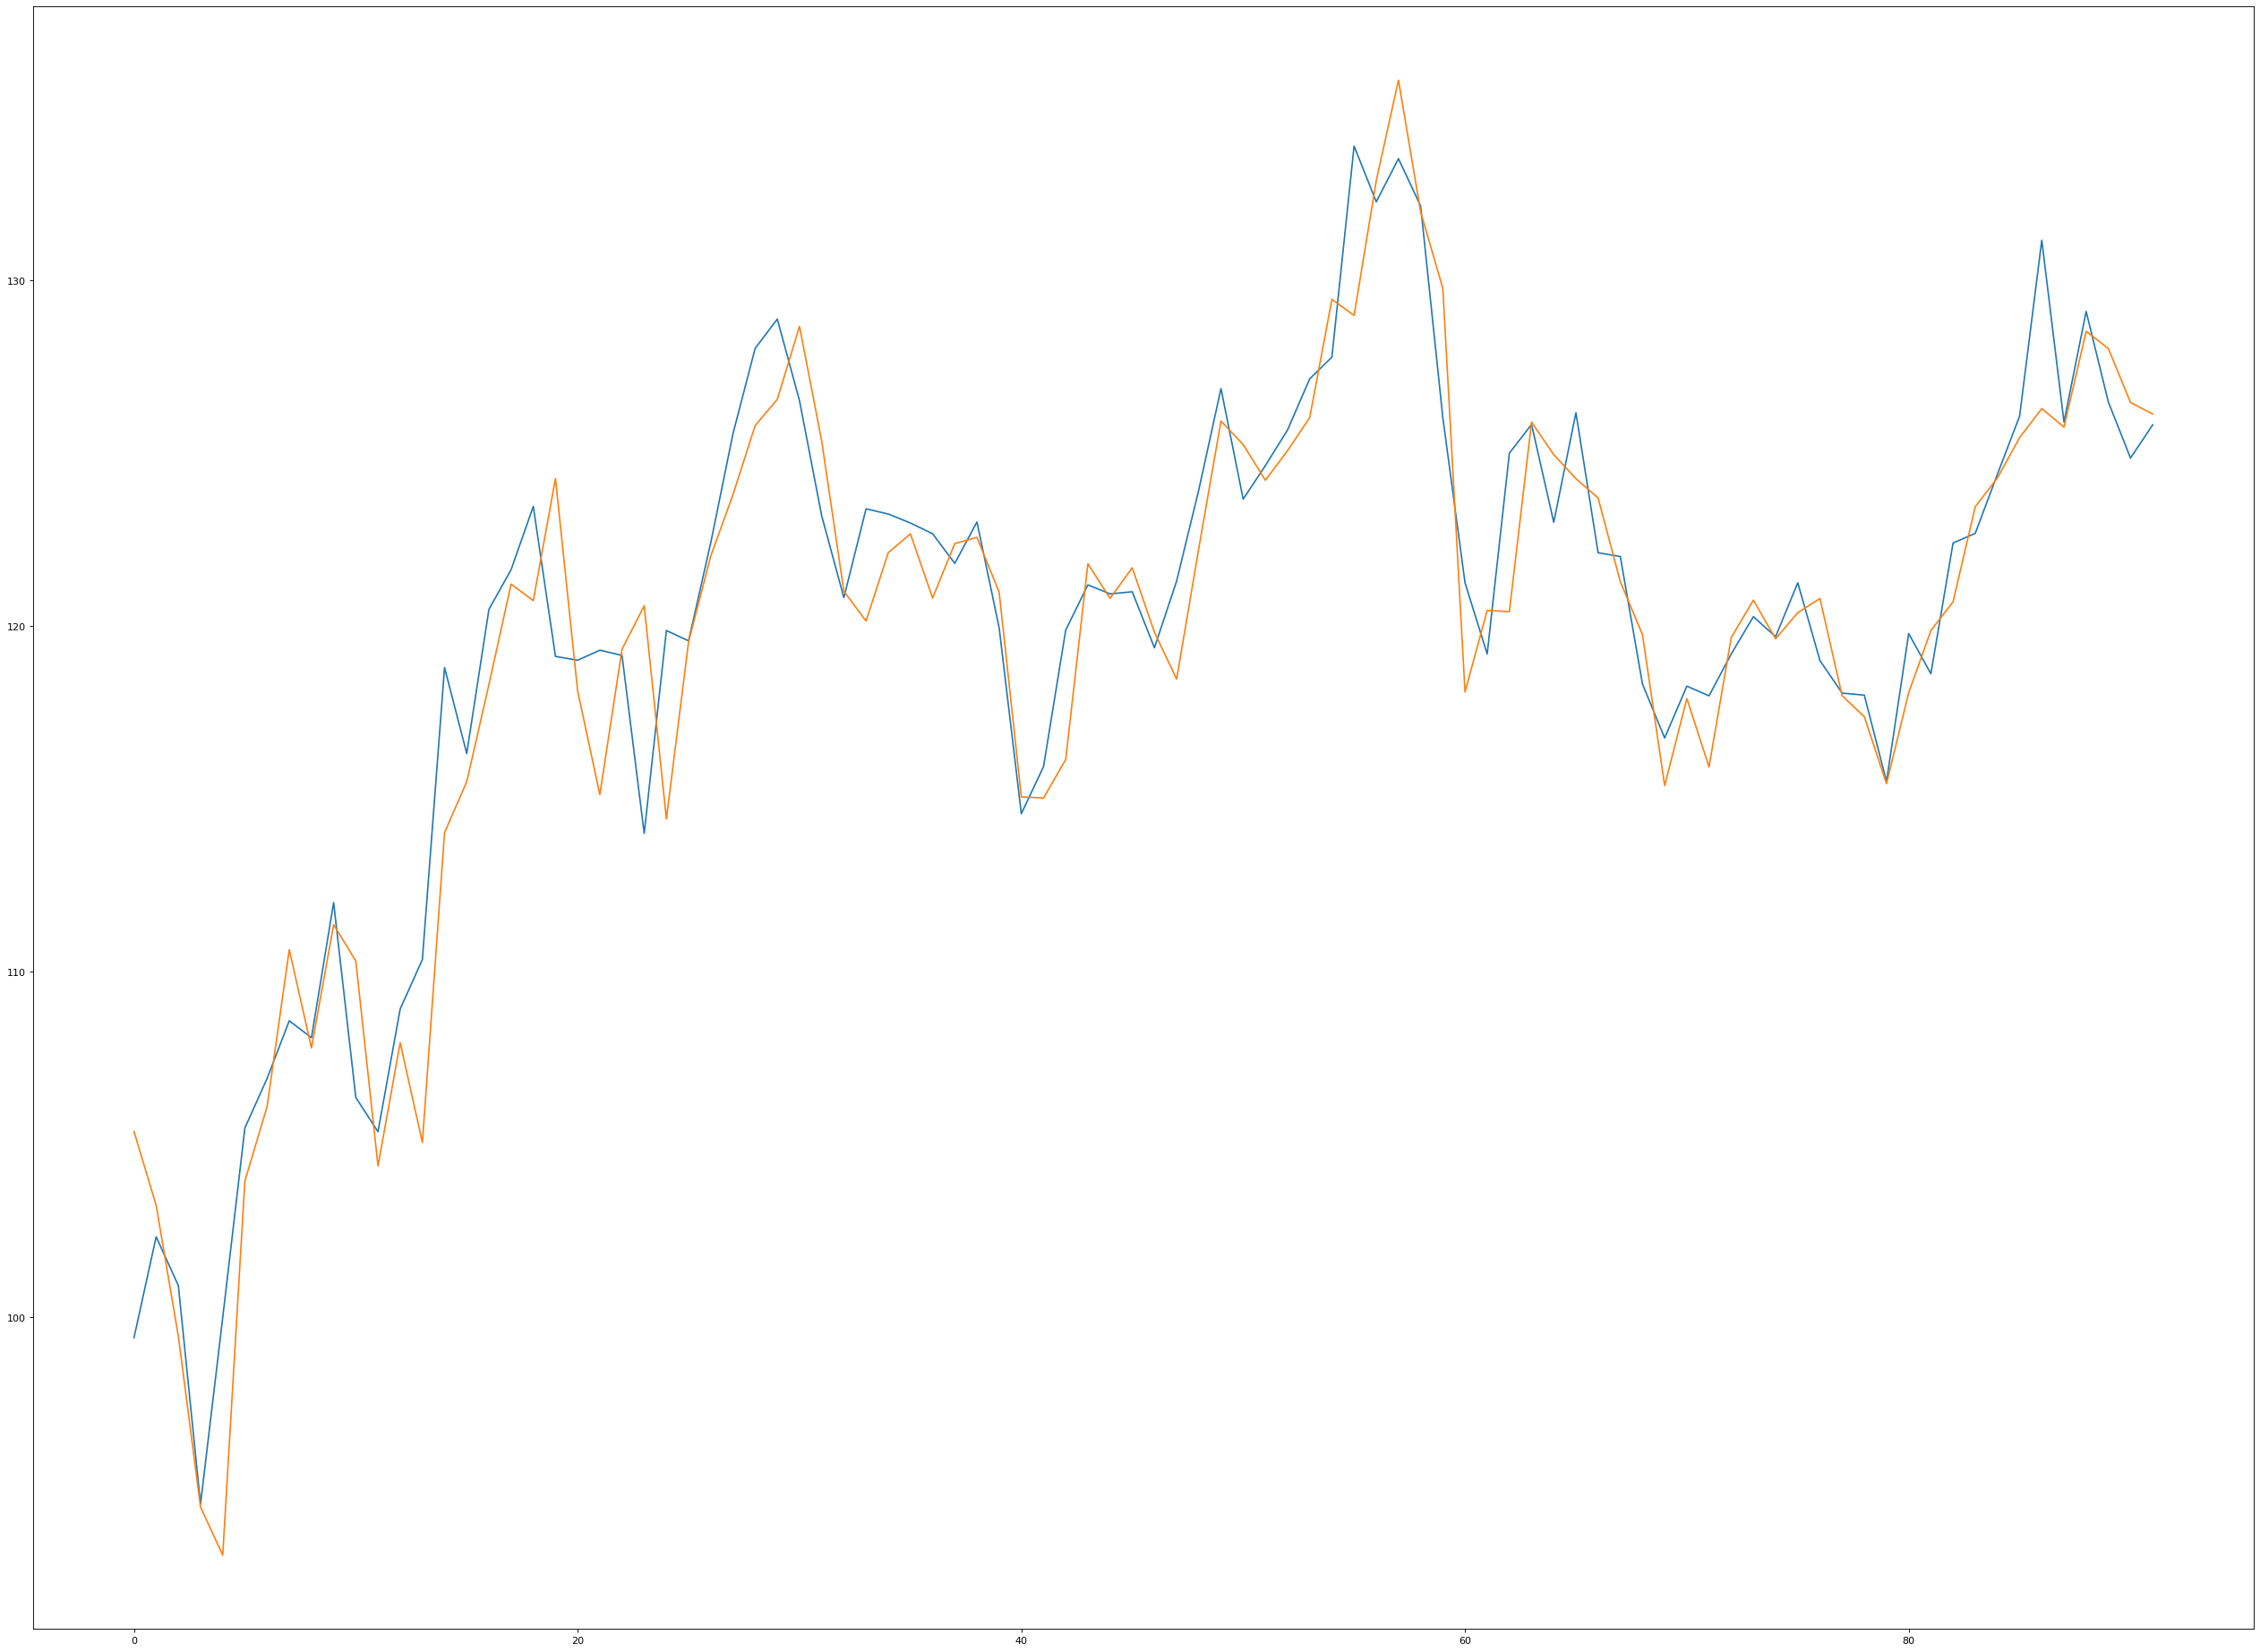

In [31]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), unscaled_y_test[-92:,0])
plt.plot(range(92), predicted_y_test[-92:,0])
plt.show()

##### Predictions over predictions for 30 days on

In [59]:
days = 30

y_subset = data.to_numpy()[-days:]

subset = np.array([data_norm[-(backlook+days):-days]])
predicted = np.array(final_model[0].predict(subset))

for i in range(days):
    subset = np.append(subset[:,1:], np.array([[predicted[-1]]]), axis=1)
    predicted = np.append(predicted, final_model[0].predict(subset), axis=0)

In [62]:
predicted = normaliser.inverse_transform(predicted)

Here we can see the model behaviour when it uses its own predictions as input for 30 days

##### Open values

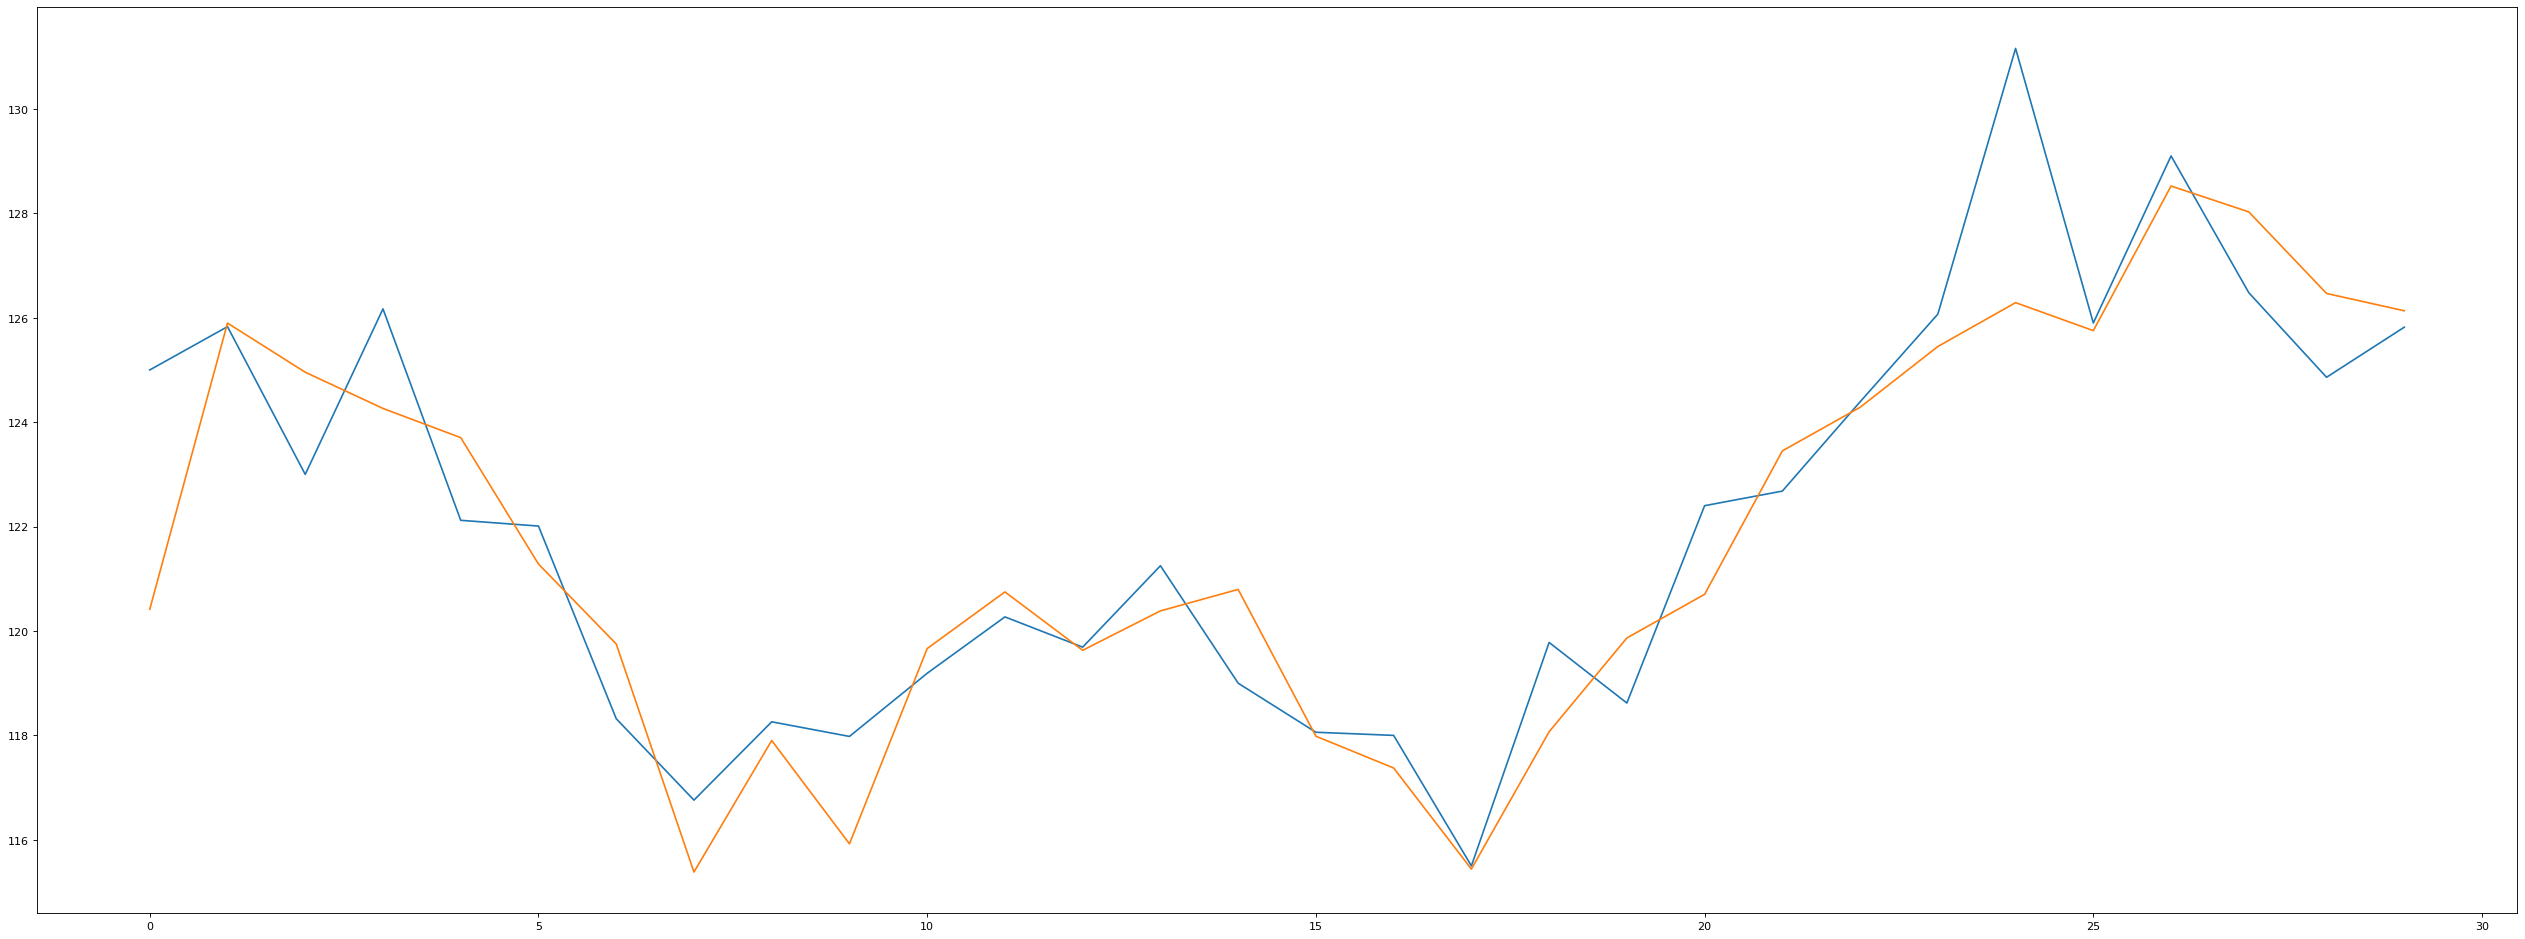

In [95]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), unscaled_y_test[-days:,0])
plt.plot(range(days), predicted_y_test[-days:,0])
plt.show()

##### High values

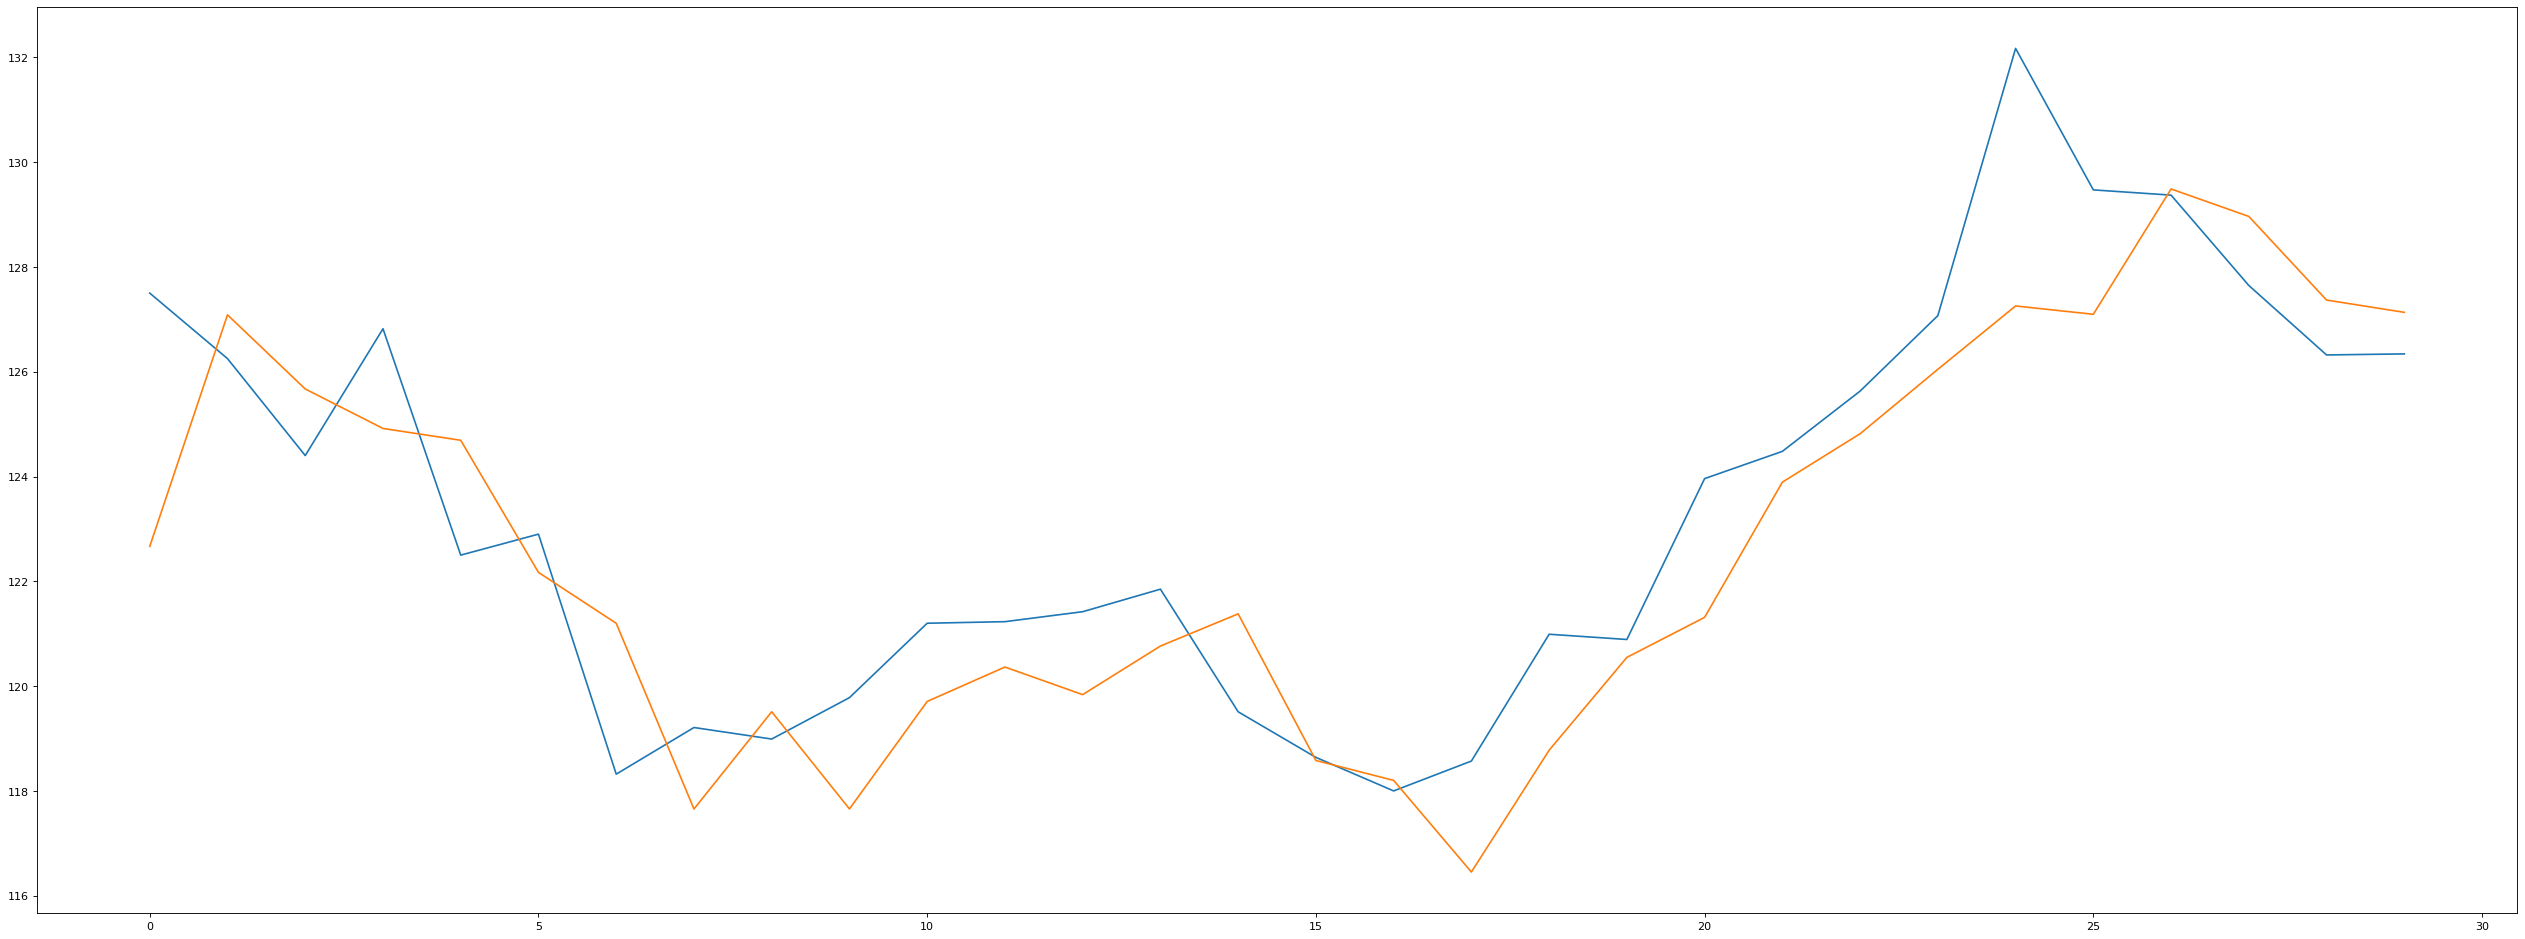

In [82]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), unscaled_y_test[-days:,1])
plt.plot(range(days), predicted_y_test[-days:,1])
plt.show()

##### Low values

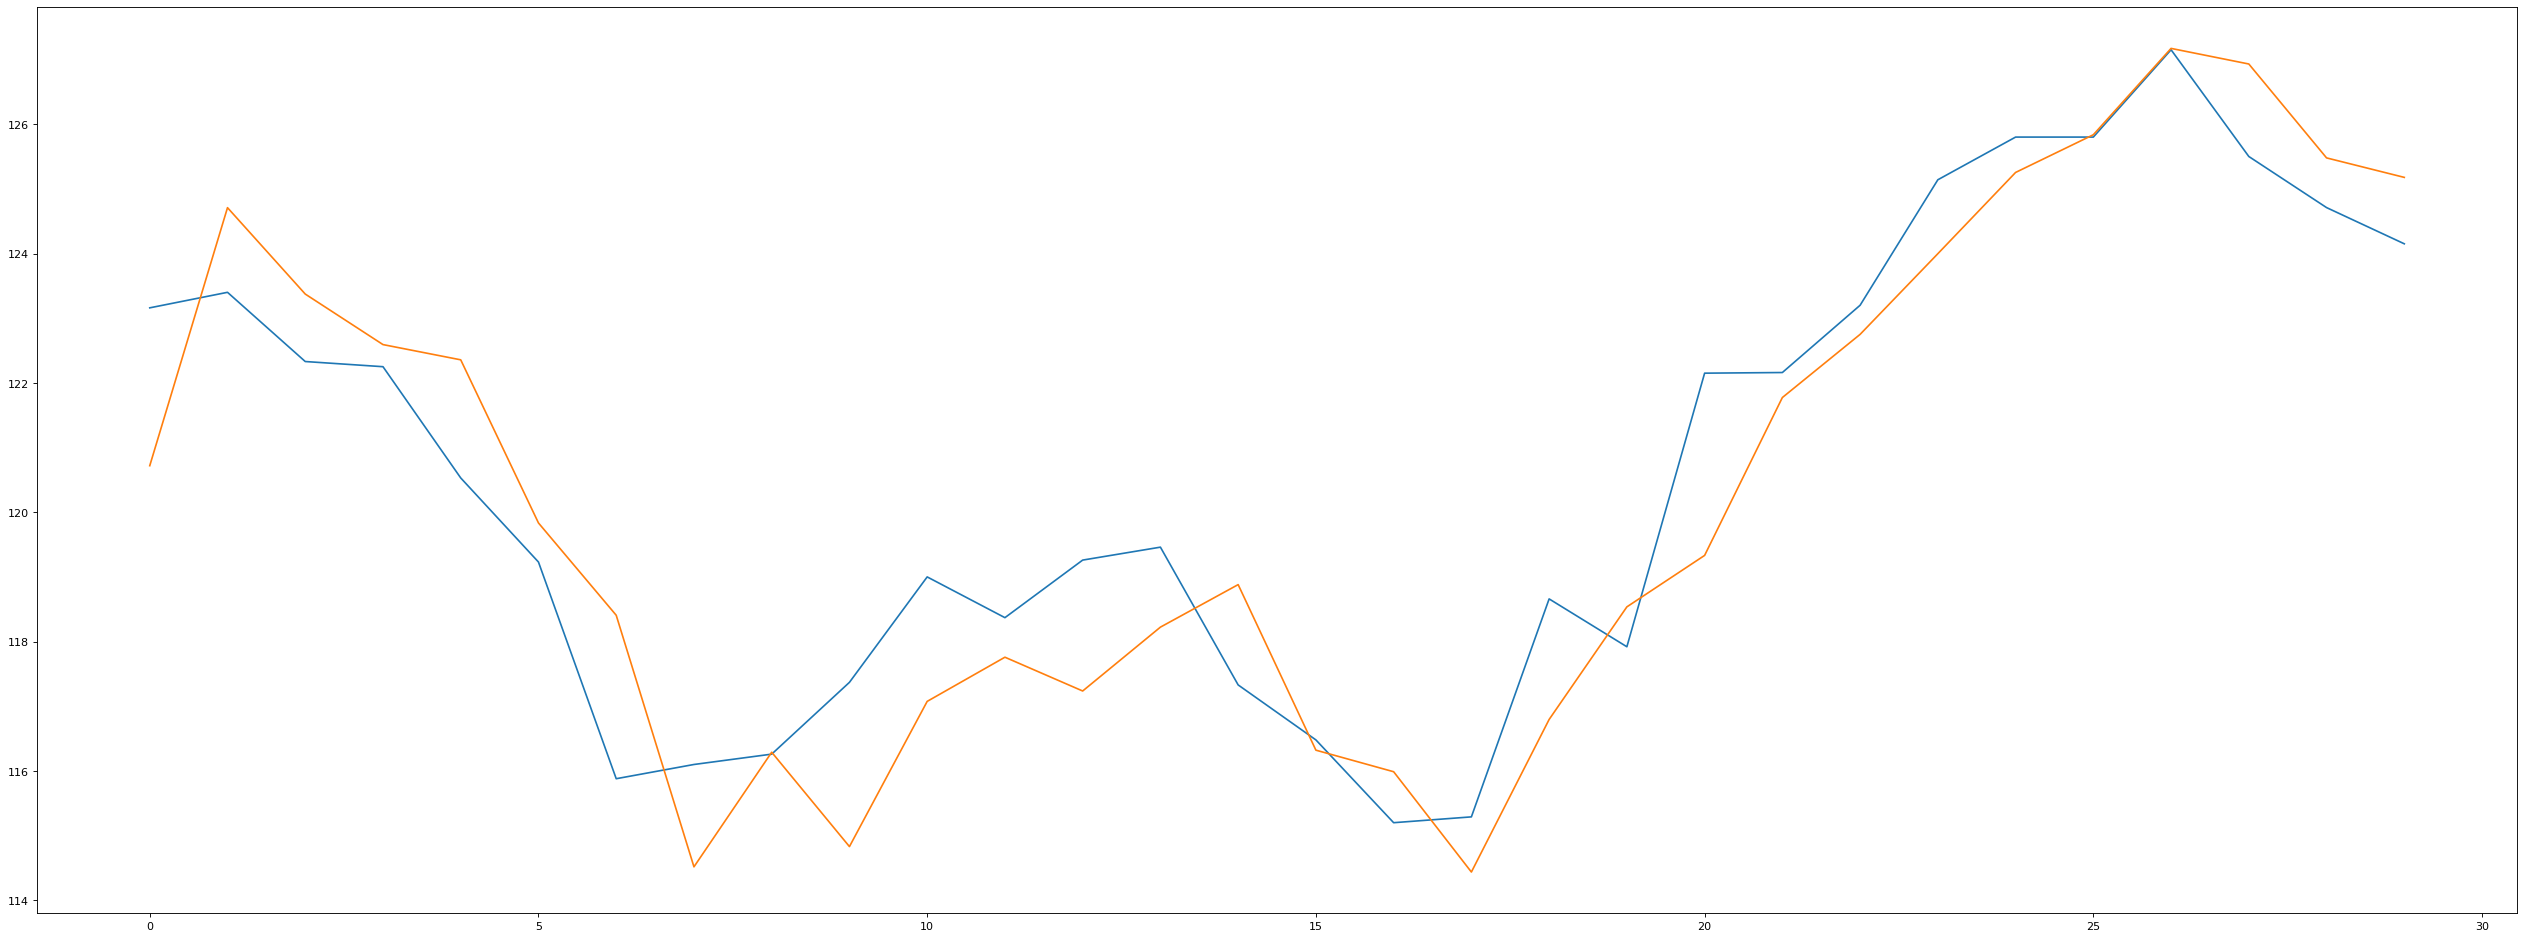

In [83]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), unscaled_y_test[-days:,2])
plt.plot(range(days), predicted_y_test[-days:,2])
plt.show()

##### Close values

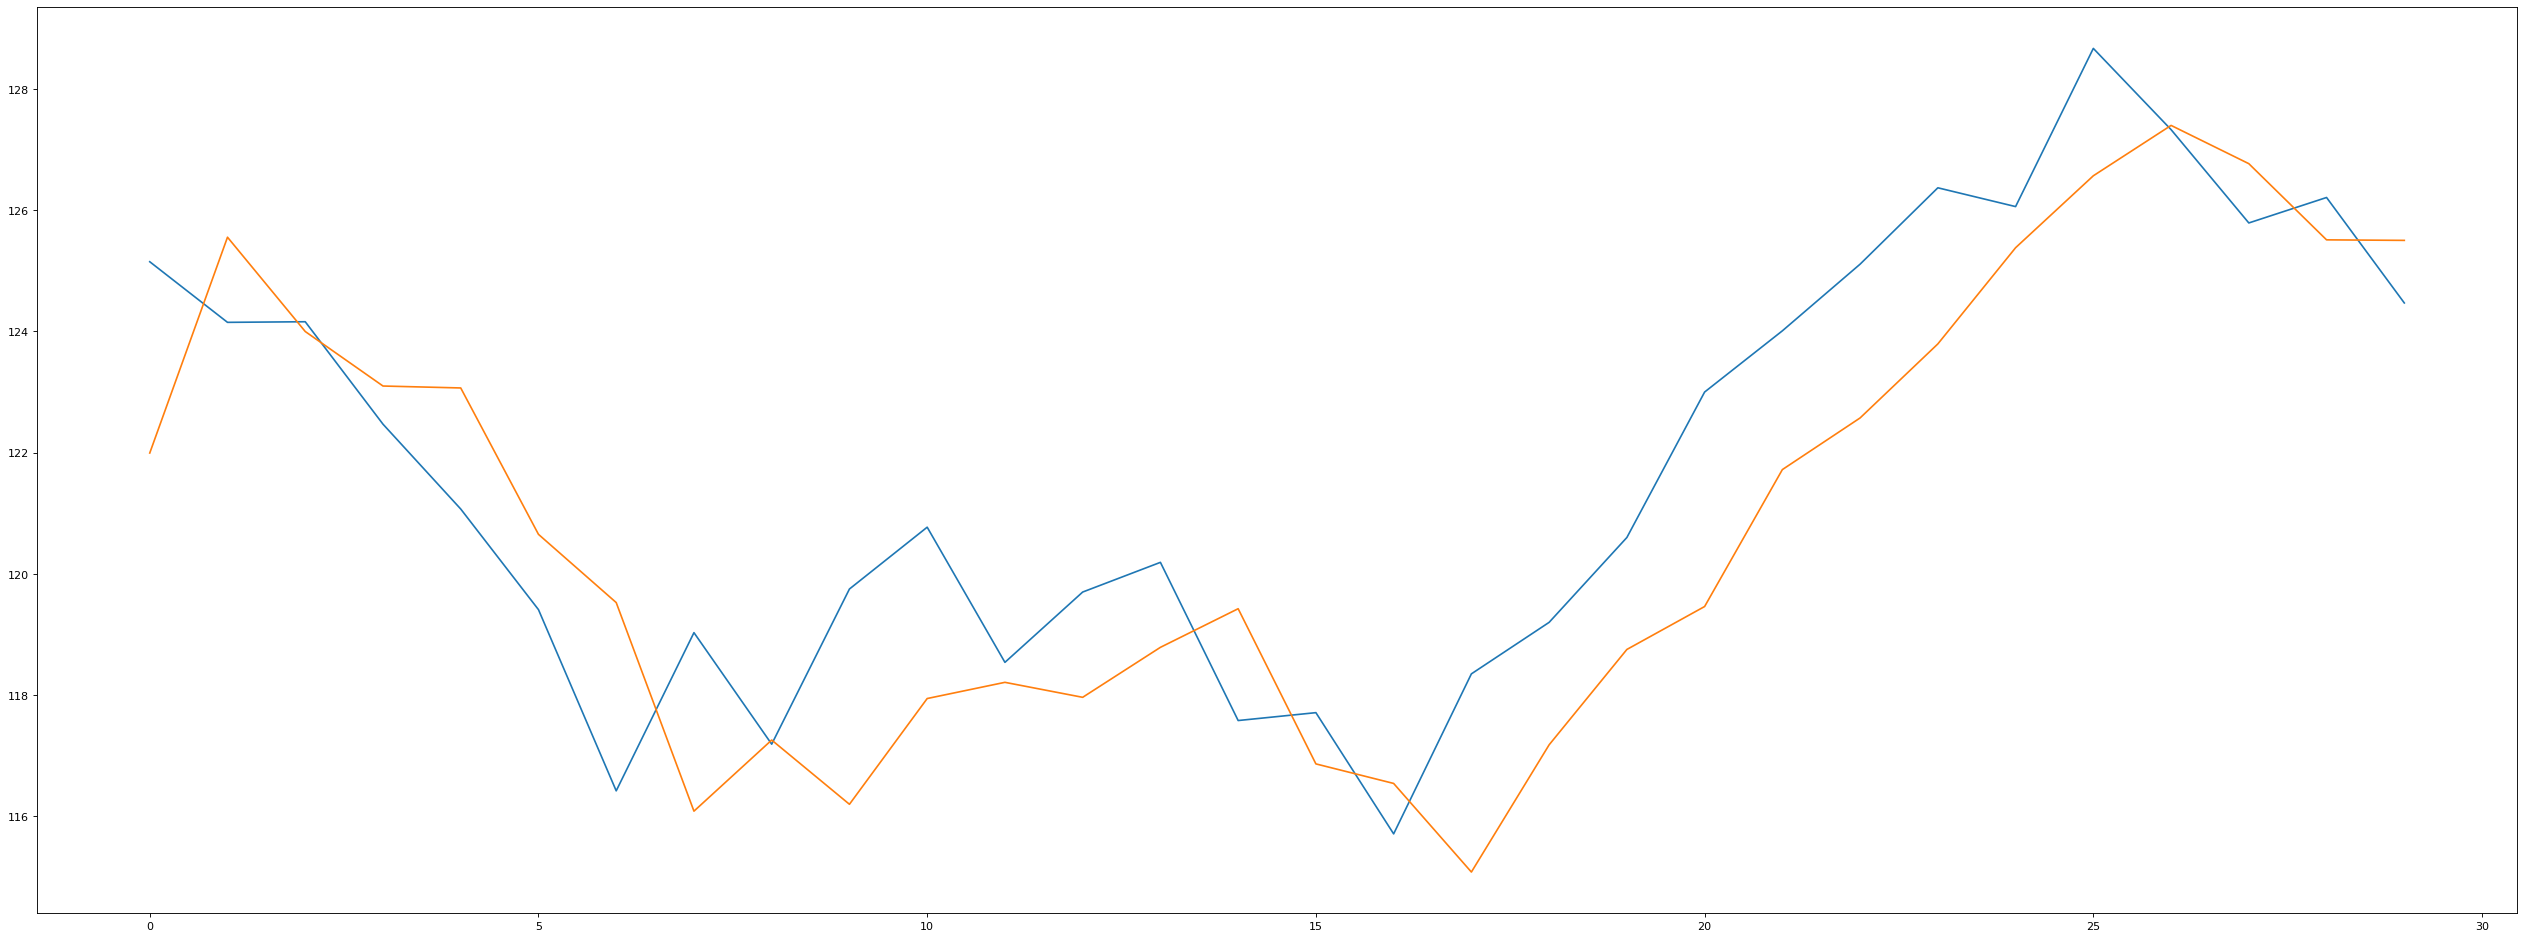

In [84]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), unscaled_y_test[-days:,3])
plt.plot(range(days), predicted_y_test[-days:,3])
plt.show()

##### Volume values

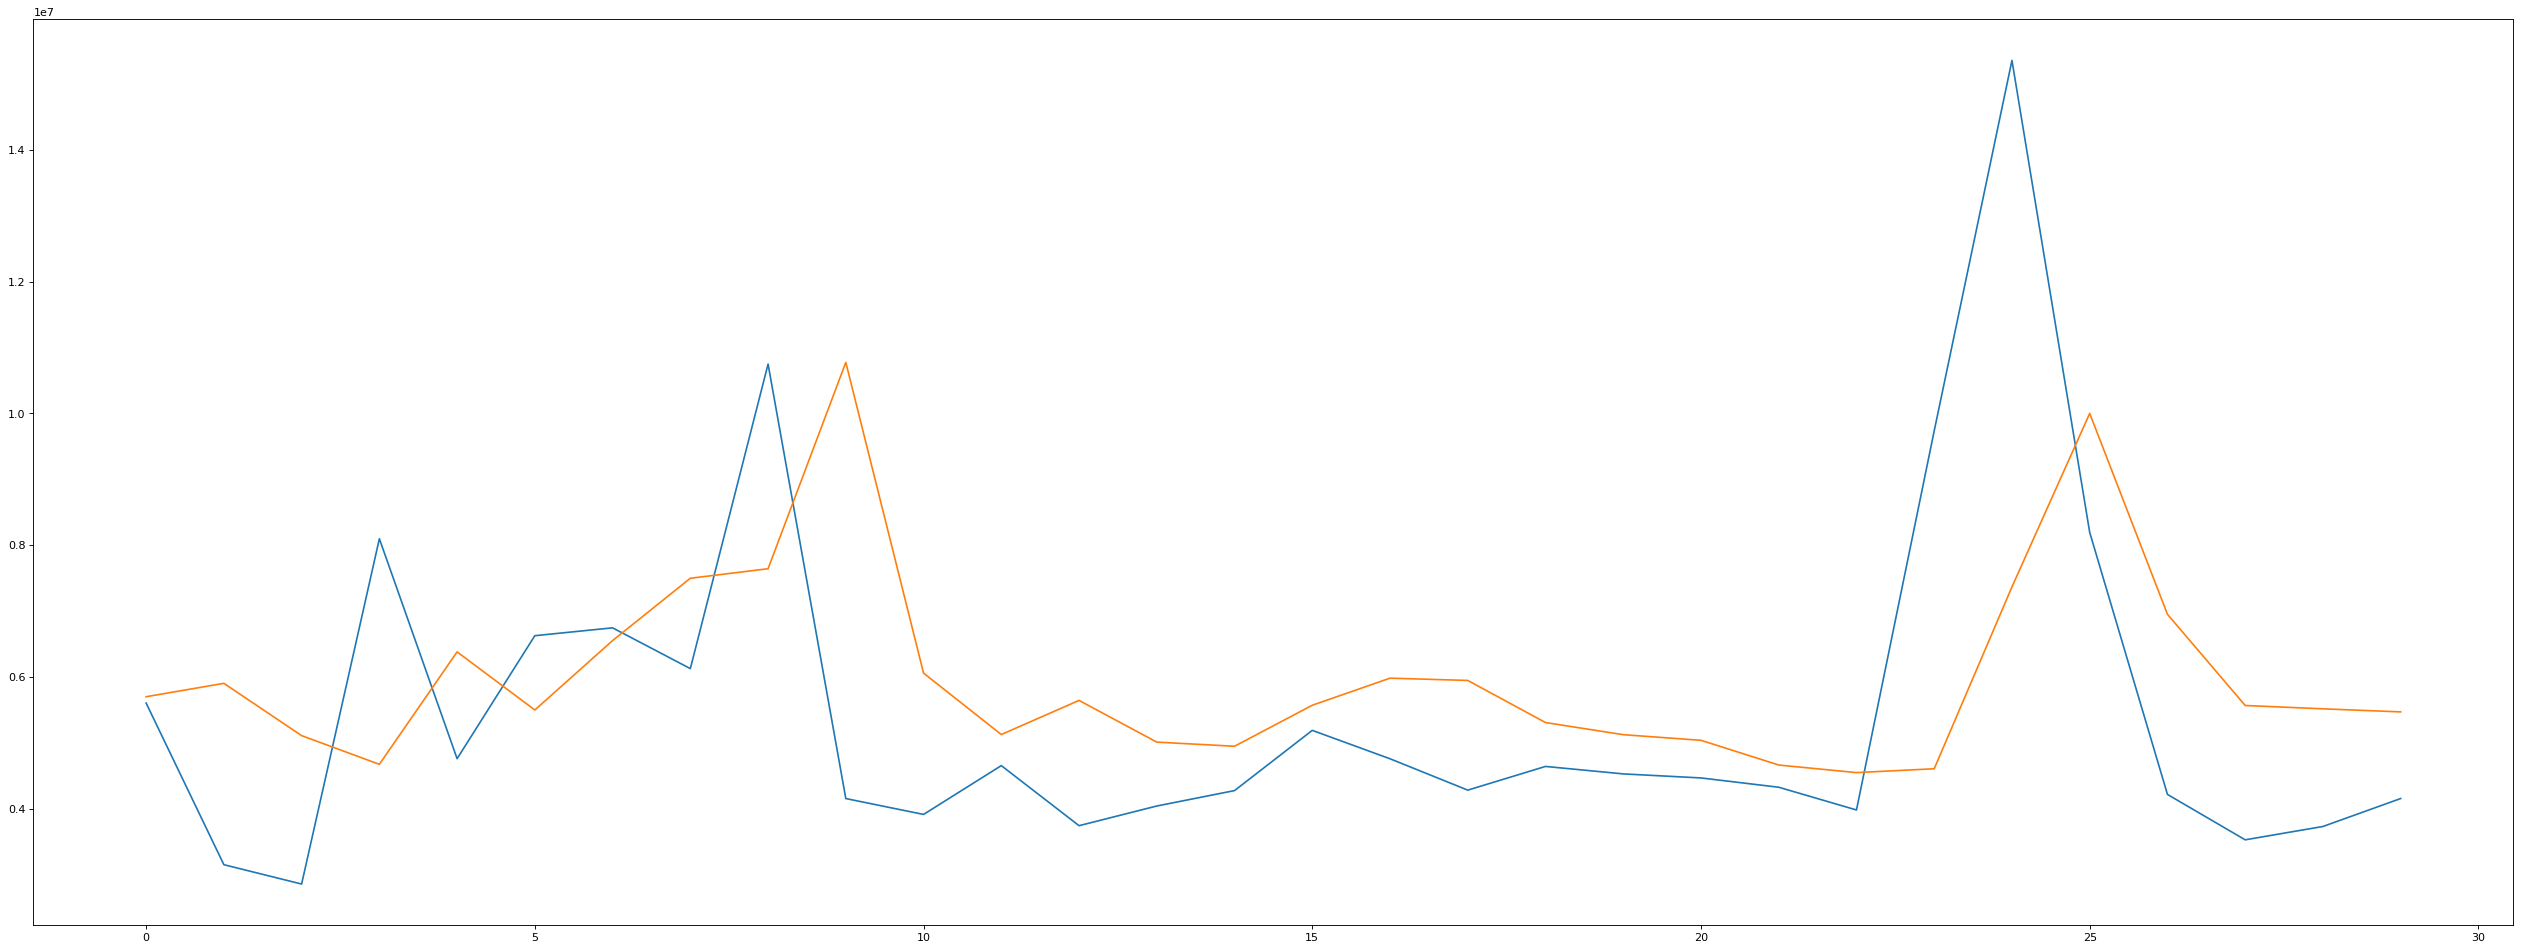

In [85]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), unscaled_y_test[-days:,4])
plt.plot(range(days), predicted_y_test[-days:,4])
plt.show()